# Homework3

# Configuration

## Key, Value

```c++
using keyType   = uint64_t;
using valueType = uint64_t;
```

## Tuple

I decide to have a more-realistic tuple in row-oriented DBMSs(Database Management Systems) with key and several payload values. The reason I don't pick column-oriented storage layout, we only check the number of join matches without any copying or materialization as input for other operators. Then using column-oriented storage layout make no difference with a tuple only containing key. With the 64-Bytes-sized tuple, we can expect the memory bus has a pressure at partition phase, since each tuple has to be copied into corresponding partition. 

```c++
/// Tuple type as naive row storage
struct alignas(64) tuple_t {
   /// Key
   keyType key;
   /// Values
   valueType value[payload_count]{0};
};

static_assert(sizeof(tuple_t) == 64);
```

## Relation, Partition

```c++
using relation = std::vector<tuple_t>;

/// A partition
struct partition {
   /// Relation for data strorage
   relation relation_;
   /// Partition metadata containing last element -- the size of the relation as the past-of-end iterator
   std::vector<size_t> start_points; // Vector containing the starts of the partitions
};
```

## Split Helper

The Split Helper has meta-data for partition. It is a common and sufficient method to use the least significant bits, since they has the diversity and can provide a good distribution.

```c++
/// Helper struct for partitioning the tuples
struct SplitHelper {
   /// fan out :== number of partitions
   const uint64_t fanOut;
   /// Mask for the actually partition bit pattern
   const uint64_t mask;
   /// Coming bits for multipass partition
   const uint64_t coming_bits;

   /// Constructor for single pass partition
   SplitHelper(uint64_t bits) : fanOut(1 << bits), mask{fanOut - 1}, coming_bits{0} {};

   /// Constructor for multiple passes
   /// Actually partition by mask := ((1 << bits) - 1) << coming_bits
   /// @param bits partition bit in this pass
   /// @param coming_bits all partition bits in future passes
   SplitHelper(uint64_t bits, uint64_t coming_bits) : fanOut(1 << bits), mask{(fanOut - 1) << coming_bits}, coming_bits{coming_bits} {}
};
```

## Join Query

```sql
SELECT COUNT(*) 
FROM r, s 
WHERE r.key = s.key
```

# Plots

## Join Types:
- Trivial Hash Join
- Partition Navie Hash Join
- Partition MultiPass Hash Join
- Partition Navie Hash Join with Software Buffer
- Partition Multi Pass Hash Join with Software Buffer

## Execution Time Breakdown of Radix-Partition

First of all, we run experiments on the last 4 Radix-Joins to find out the Radix-Bit Pattern with good performance. In this section, two relations have a same fixed size: 512 MiB.
We can observe how these 4 optimized hash joins(radix joins) behavior.

In [74]:
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
import math
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 9) # (w, h)

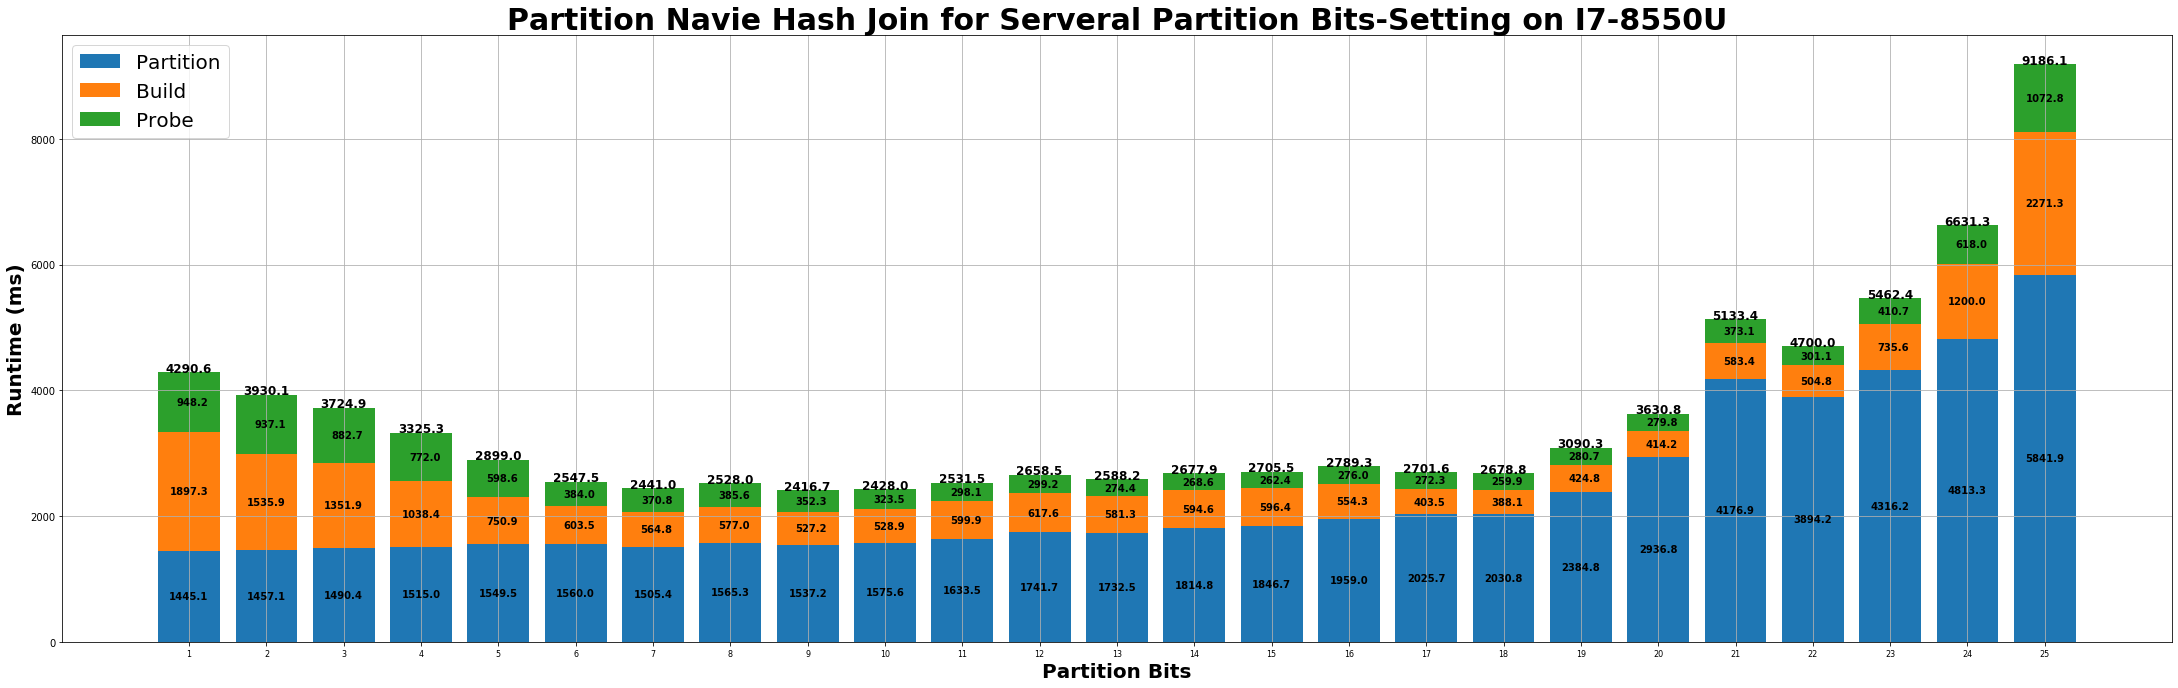

<Figure size 28800x14400 with 0 Axes>

In [82]:
df_i7_1    = pd.read_csv("I7-8550u/PartitionNavieHashJoin.csv")
bits   = df_i7_1['bits']
bits  = np.array([str(item) for item in bits])
all_1  = df_i7_1['all']
all_1  = np.array([float(item) for item in all_1])
partition_1  = df_i7_1['partition']
partition_1  = np.array([float(item) for item in partition_1])
build_1      = df_i7_1['build']
build_1      = np.array([float(item) for item in build_1])
probe_1      = df_i7_1['probe']
probe_1      = np.array([float(item) for item in probe_1])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_1, label='Partition')
ax.bar(bits, build_1, bottom=partition_1, label='Build')
ax.bar(bits, probe_1, bottom=(partition_1+build_1), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_1):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Navie Hash Join for Serveral Radix-Bits on I7-8550U', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

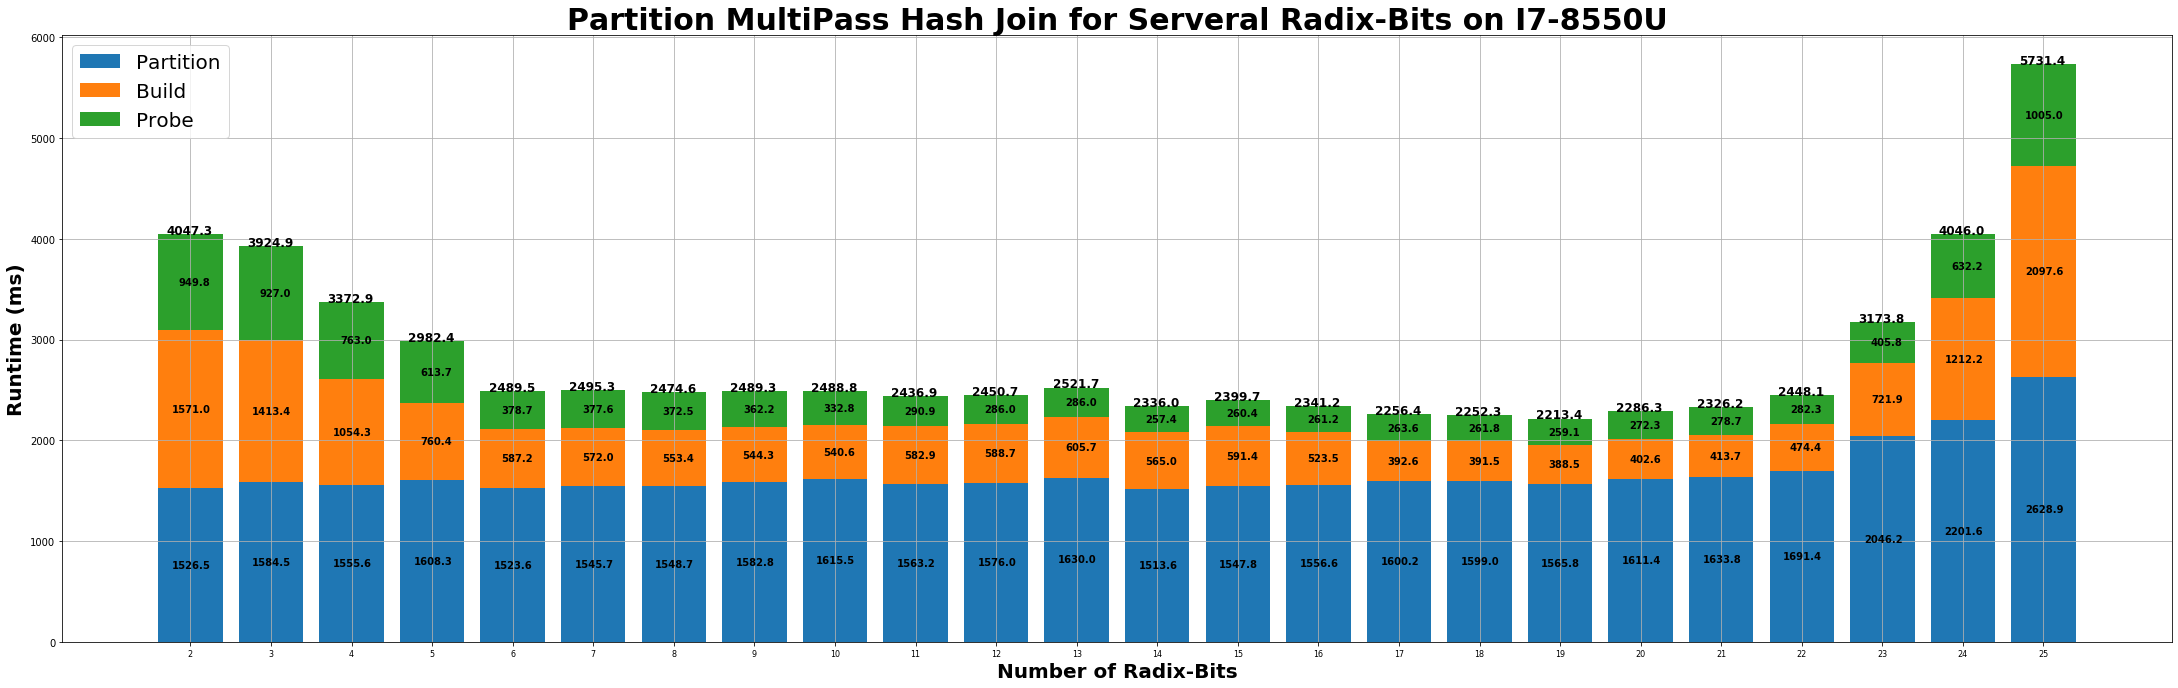

<Figure size 28800x14400 with 0 Axes>

In [84]:
df_i7_2    = pd.read_csv("I7-8550u/PartitionMultiPassHashJoin.csv")
bits   = df_i7_2['bits']
bits  = np.array([str(item) for item in bits])
all_2  = df_i7_2['all']
all_2  = np.array([float(item) for item in all_2])
partition_2  = df_i7_2['partition']
partition_2  = np.array([float(item) for item in partition_2])
build_2      = df_i7_2['build']
build_2      = np.array([float(item) for item in build_2])
probe_2      = df_i7_2['probe']
probe_2      = np.array([float(item) for item in probe_2])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_2, label='Partition')
ax.bar(bits, build_2, bottom=partition_2, label='Build')
ax.bar(bits, probe_2, bottom=(partition_2+build_2), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_2):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition MultiPass Hash Join for Serveral Radix-Bits on I7-8550U', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

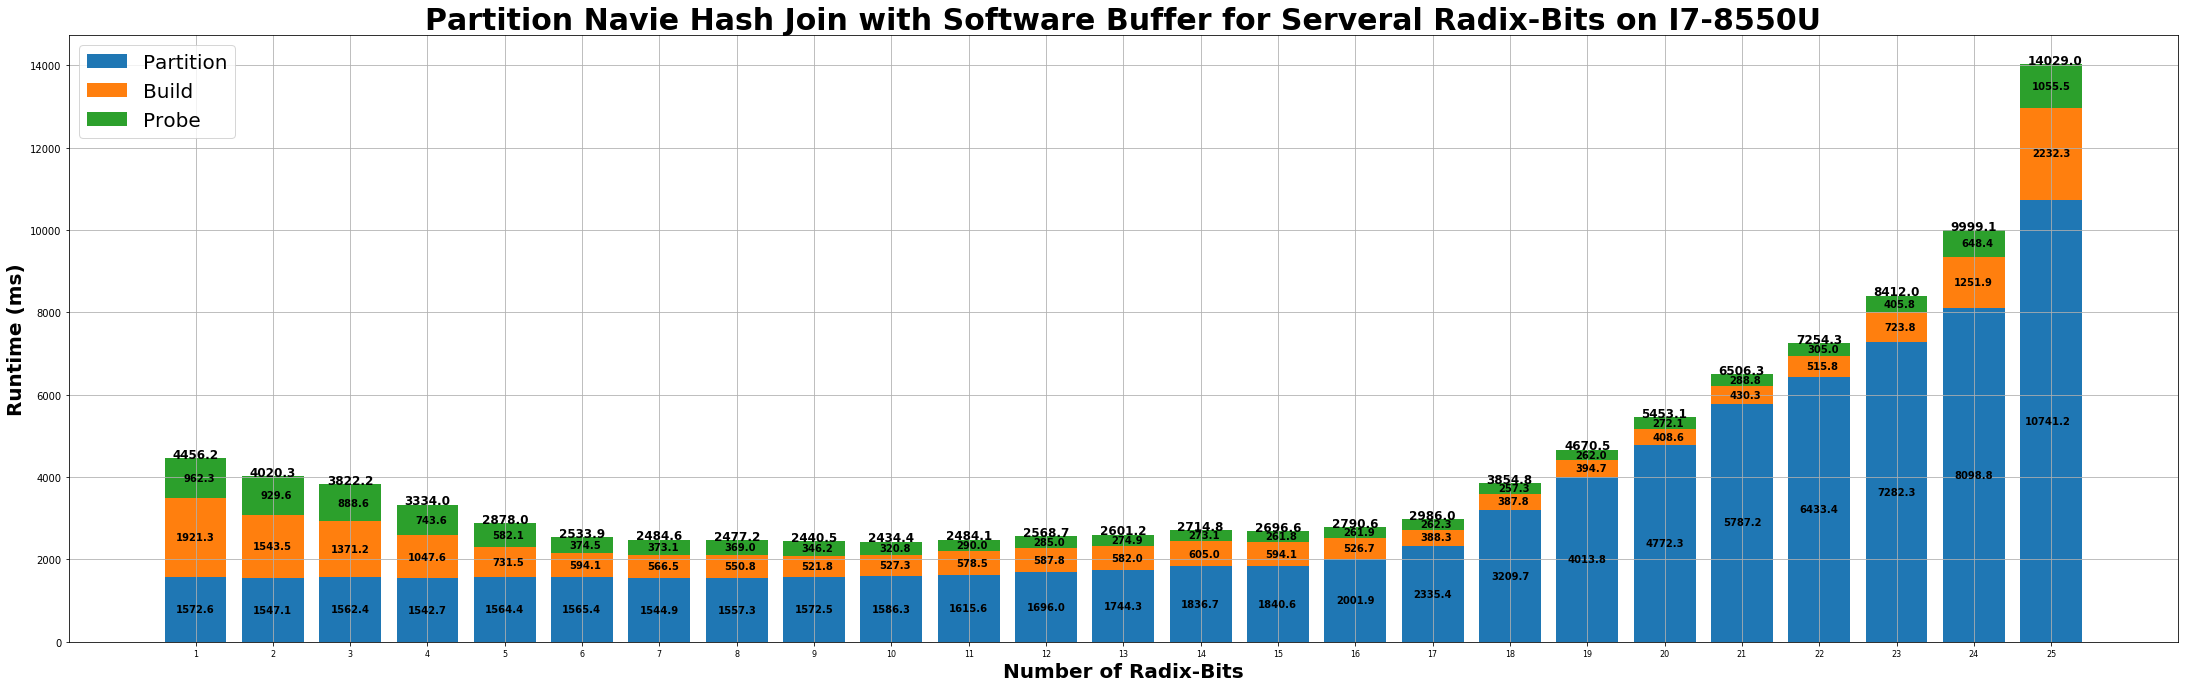

<Figure size 28800x14400 with 0 Axes>

In [87]:
df_i7_3    = pd.read_csv("I7-8550u/PartitionNavieHashJoinSoftwareBuffer.csv")
bits   = df_i7_3['bits']
bits  = np.array([str(item) for item in bits])
all_3  = df_i7_3['all']
all_3  = np.array([float(item) for item in all_3])
partition_3  = df_i7_3['partition']
partition_3  = np.array([float(item) for item in partition_3])
build_3      = df_i7_3['build']
build_3      = np.array([float(item) for item in build_3])
probe_3      = df_i7_3['probe']
probe_3      = np.array([float(item) for item in probe_3])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_3, label='Partition')
ax.bar(bits, build_3, bottom=partition_3, label='Build')
ax.bar(bits, probe_3, bottom=(partition_3+build_3), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_3):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Navie Hash Join with Software Buffer for Serveral Radix-Bits on I7-8550U', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

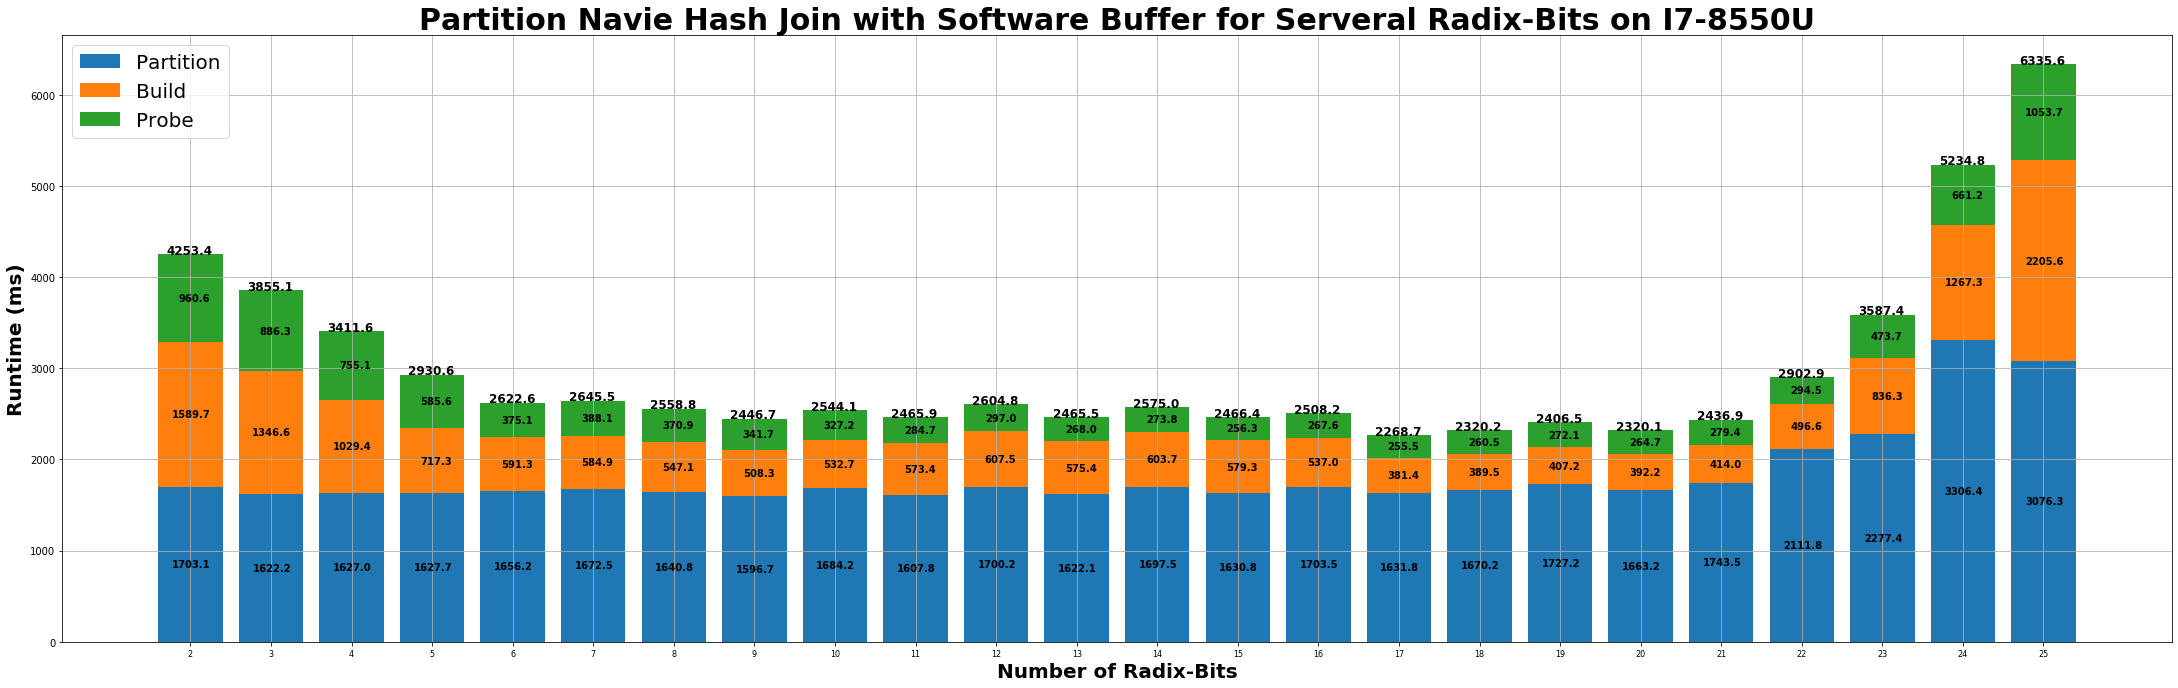

<Figure size 28800x14400 with 0 Axes>

In [88]:
df_i7_4    = pd.read_csv("I7-8550u/PartitionMultiPassHashJoinSoftwareBuffer.csv")
bits   = df_i7_4['bits']
bits  = np.array([str(item) for item in bits])
all_4  = df_i7_4['all']
all_4  = np.array([float(item) for item in all_4])
partition_4  = df_i7_4['partition']
partition_4  = np.array([float(item) for item in partition_4])
build_4      = df_i7_4['build']
build_4      = np.array([float(item) for item in build_4])
probe_4      = df_i7_4['probe']
probe_4      = np.array([float(item) for item in probe_4])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_4, label='Partition')
ax.bar(bits, build_4, bottom=partition_4, label='Build')
ax.bar(bits, probe_4, bottom=(partition_4+build_4), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_4):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Multi Pass Hash Join with Software Buffer for Serveral Radix-Bits on I7-8550U', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

From the 4 huge figures, it is important to point out, too many or too less radix-bits is not helpful at all. But I still record them, in order to show the trend of each figure. We can observe that, the optimization does not offer a step-by-step optimized result. since these 4 figures shared a simlar best runtime. But the multipass and software buffer can mild down the partition cost, thus make the distribution more uniformly.

## Partitioning Performance Comparison

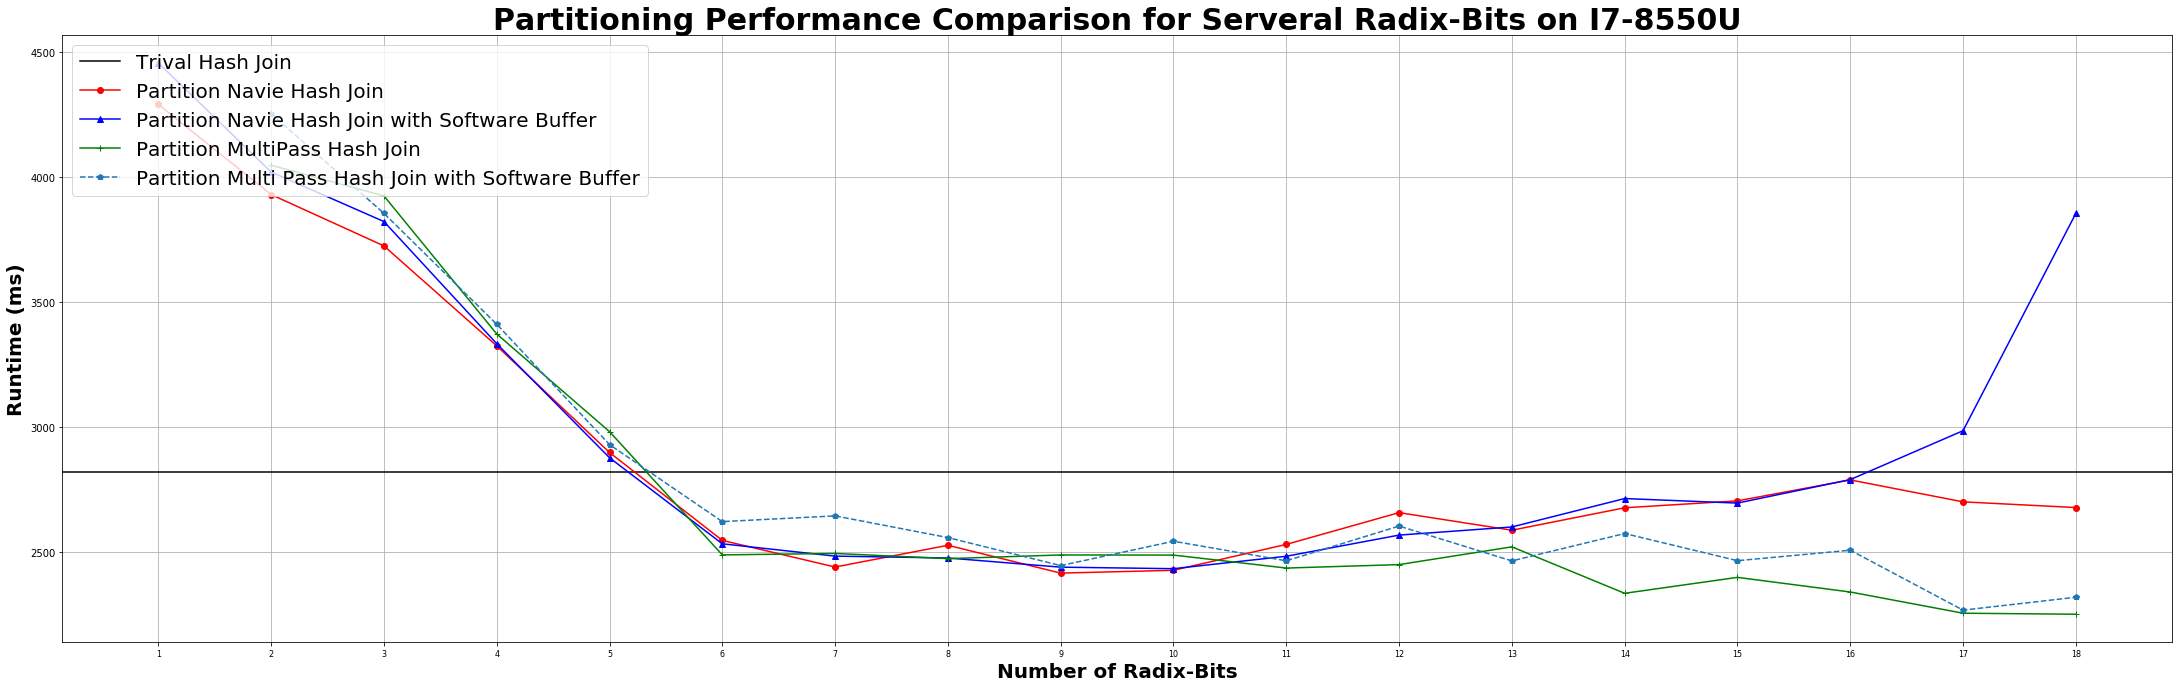

<Figure size 28800x14400 with 0 Axes>

In [152]:
df_i7_0   = pd.read_csv("I7-8550u/TrivialHashJoin.csv")
all_0   = df_i7_0['all']

df_i7_1    = pd.read_csv("I7-8550u/PartitionNavieHashJoin.csv")
bits   = df_i7_1['bits']
bits  = [str(item) for item in bits]

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()


ax.axhline(y=all_0[0], xmin=0.0, xmax=1.0, color='black')
plt.plot(bits[:18], all_1[:18], 'ro-', bits[:18], all_3[:18], 'b^-')
plt.plot(bits[1:18], all_2[:17], 'g+-', bits[1:18], all_4[:17], 'p--')

plt.title('Partitioning Performance Comparison for Serveral Radix-Bits on I7-8550U', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
plt.legend(['Trival Hash Join', 'Partition Navie Hash Join', 'Partition Navie Hash Join with Software Buffer', 'Partition MultiPass Hash Join', 'Partition Multi Pass Hash Join with Software Buffer'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

## Throughput with Varying Relation Cardinalities

This section the experiments with varying relation size are performed. I decide not to have a large varying size range, because it is hard to control variable within these five different join pattern. I decide only pick out the best performance case in each join type, so they do not necessarily to have the same partition bit configuration.


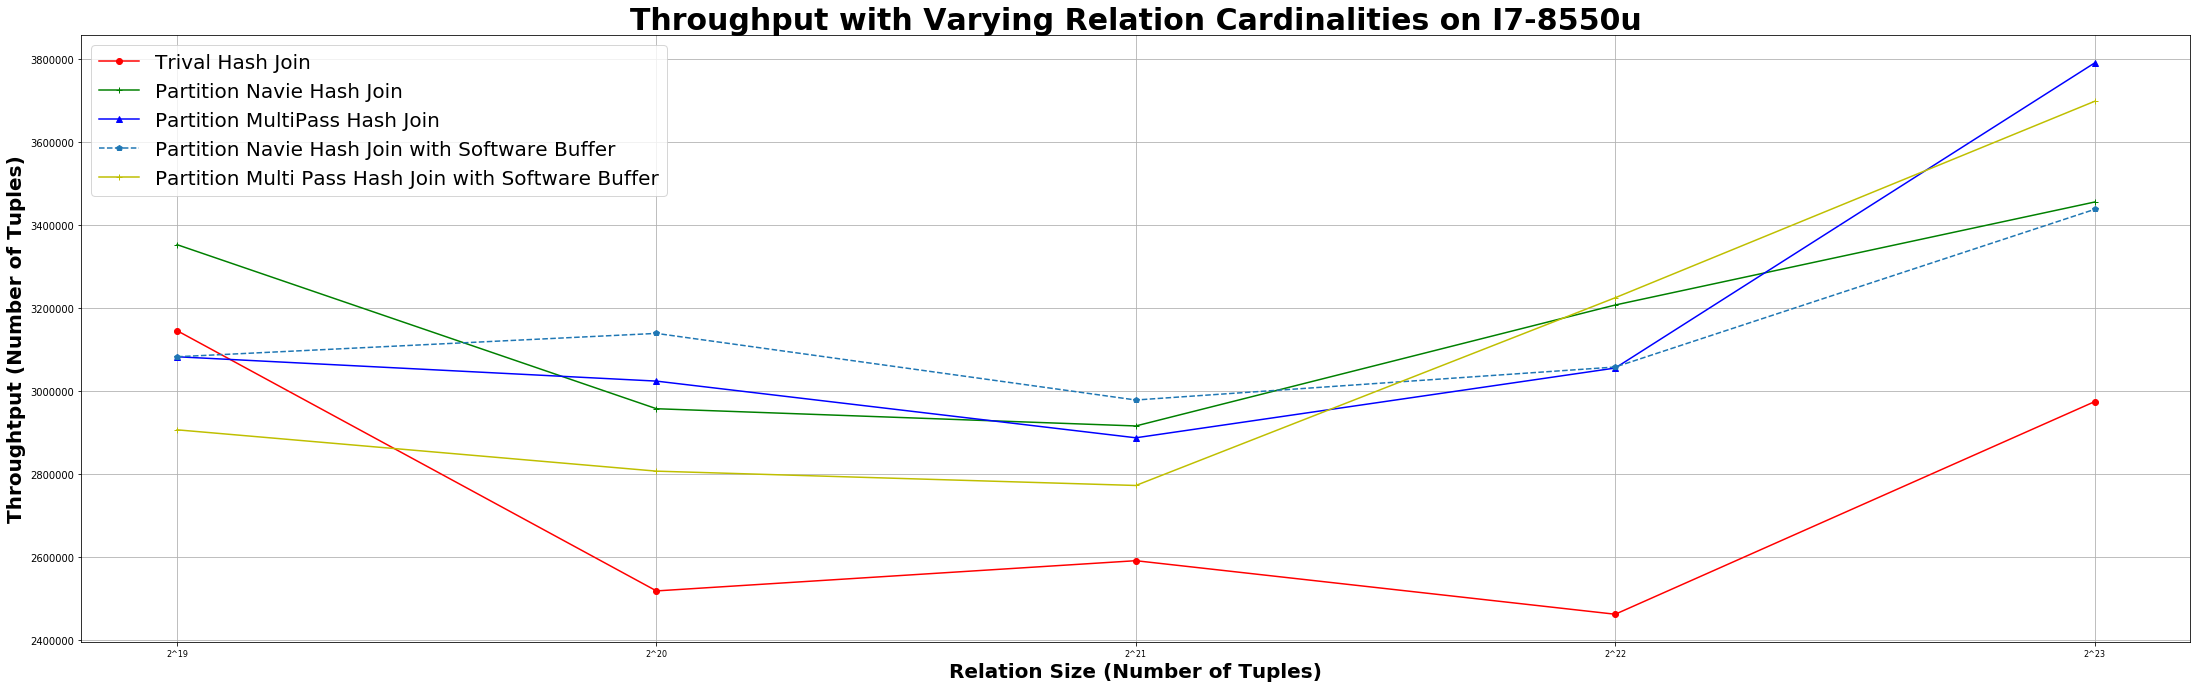

<Figure size 28800x14400 with 0 Axes>

In [185]:
df_i7   = pd.read_csv("I7-8550u/VaryingSize.csv")

df_i7_0 = df_i7[df_i7['type'] == 0]
df_i7_1 = df_i7[df_i7['type'] == 1]
df_i7_2 = df_i7[df_i7['type'] == 2]
df_i7_3 = df_i7[df_i7['type'] == 3]
df_i7_4 = df_i7[df_i7['type'] == 4]

df_i7_0_time = np.array(df_i7_0['time'])
df_i7_1_time = np.array(df_i7_1['time'])
df_i7_2_time = np.array(df_i7_2['time'])
df_i7_3_time = np.array(df_i7_3['time'])
df_i7_4_time = np.array(df_i7_4['time'])

df_i7_0_th = [0, 0, 0, 0, 0]
df_i7_1_th = [0, 0, 0, 0, 0]
df_i7_2_th = [0, 0, 0, 0, 0]
df_i7_3_th = [0, 0, 0, 0, 0]
df_i7_4_th = [0, 0, 0, 0, 0]

for i in range(5):
    df_i7_0_th[i] = (1 << (19 + i)) / (df_i7_0_time[i] / 1000)
    df_i7_1_th[i] = (1 << (19 + i)) / (df_i7_1_time[i] / 1000)
    df_i7_2_th[i] = (1 << (19 + i)) / (df_i7_2_time[i] / 1000)
    df_i7_3_th[i] = (1 << (19 + i)) / (df_i7_3_time[i] / 1000)
    df_i7_4_th[i] = (1 << (19 + i)) / (df_i7_4_time[i] / 1000)

x = ['2^19', '2^20', '2^21', '2^22', '2^23']

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
plt.plot(x,df_i7_0_th,'ro-',x,df_i7_1_th,'g+-', x,df_i7_2_th,'b^-', x,df_i7_3_th,'p--', x, df_i7_4_th, 'y+-')

plt.title('Throughput with Varying Relation Cardinalities on I7-8550u', fontsize=30, fontweight='bold')
plt.xlabel('Relation Size (Number of Tuples)', fontsize=20, fontweight='bold')
plt.ylabel('Throughtput (Number of Tuples)', fontsize=20, fontweight='bold')
plt.legend(['Trival Hash Join', 'Partition Navie Hash Join', 'Partition MultiPass Hash Join', 'Partition Navie Hash Join with Software Buffer', 'Partition Multi Pass Hash Join with Software Buffer'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

## Other Hardware

### E5-2660

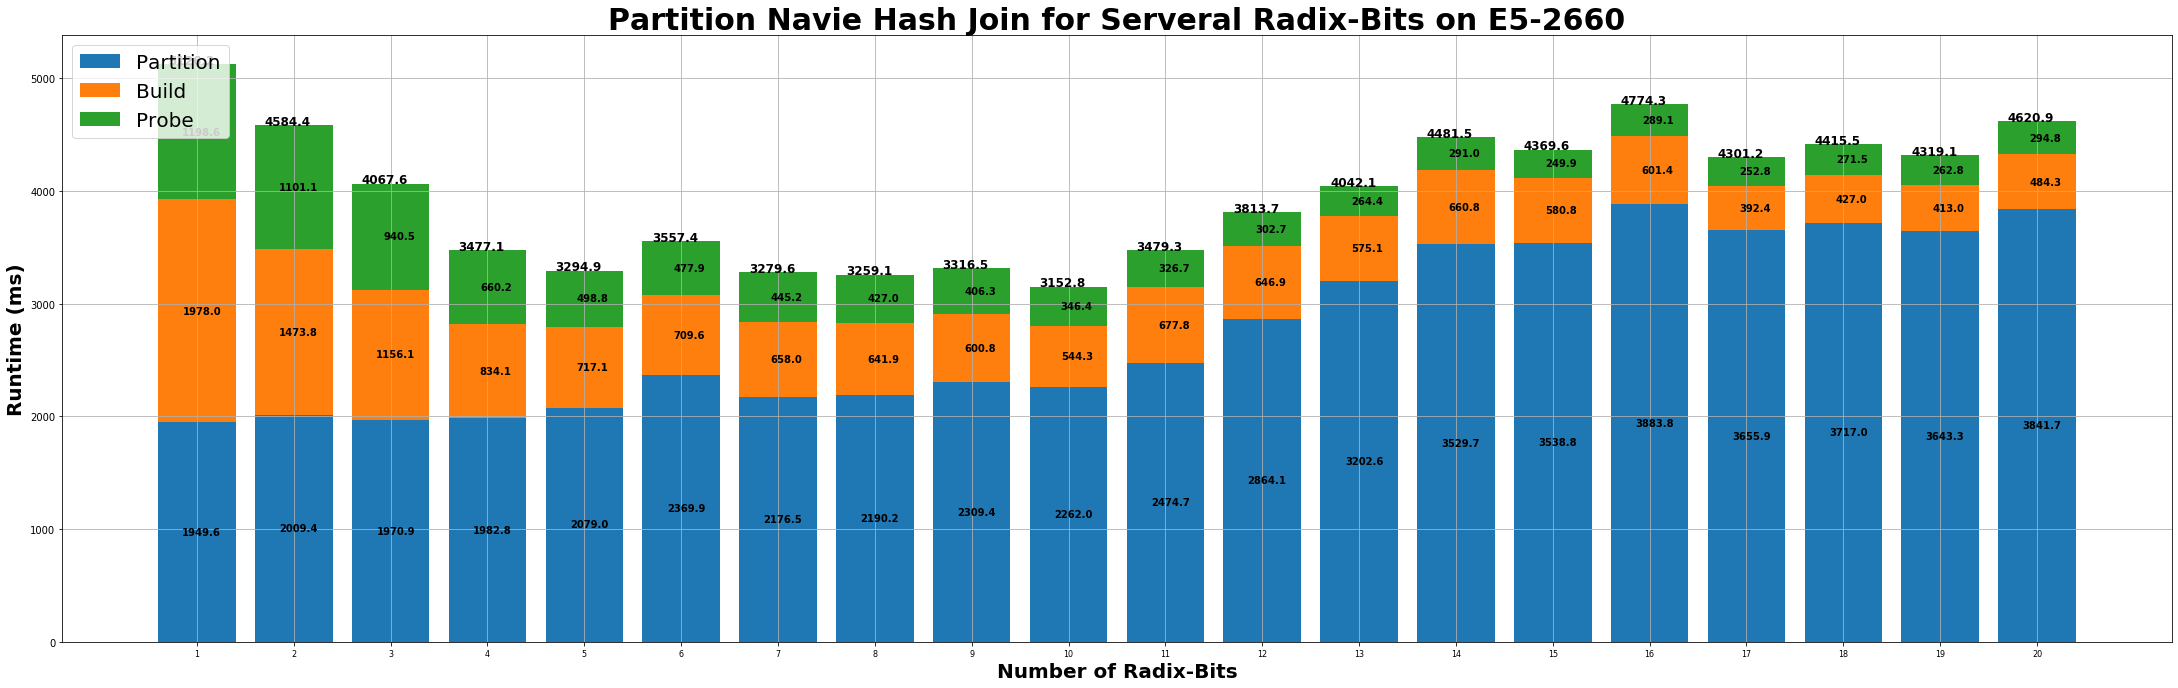

<Figure size 28800x14400 with 0 Axes>

In [186]:
df_e5_1    = pd.read_csv("E5-2660/PartitionNavieHashJoin.csv")
bits   = df_e5_1['bits']
bits  = np.array([str(item) for item in bits])
all_1  = df_e5_1['all']
all_1  = np.array([float(item) for item in all_1])
partition_1  = df_e5_1['partition']
partition_1  = np.array([float(item) for item in partition_1])
build_1      = df_e5_1['build']
build_1      = np.array([float(item) for item in build_1])
probe_1      = df_e5_1['probe']
probe_1      = np.array([float(item) for item in probe_1])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_1, label='Partition')
ax.bar(bits, build_1, bottom=partition_1, label='Build')
ax.bar(bits, probe_1, bottom=(partition_1+build_1), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_1):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Navie Hash Join for Serveral Radix-Bits on E5-2660', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

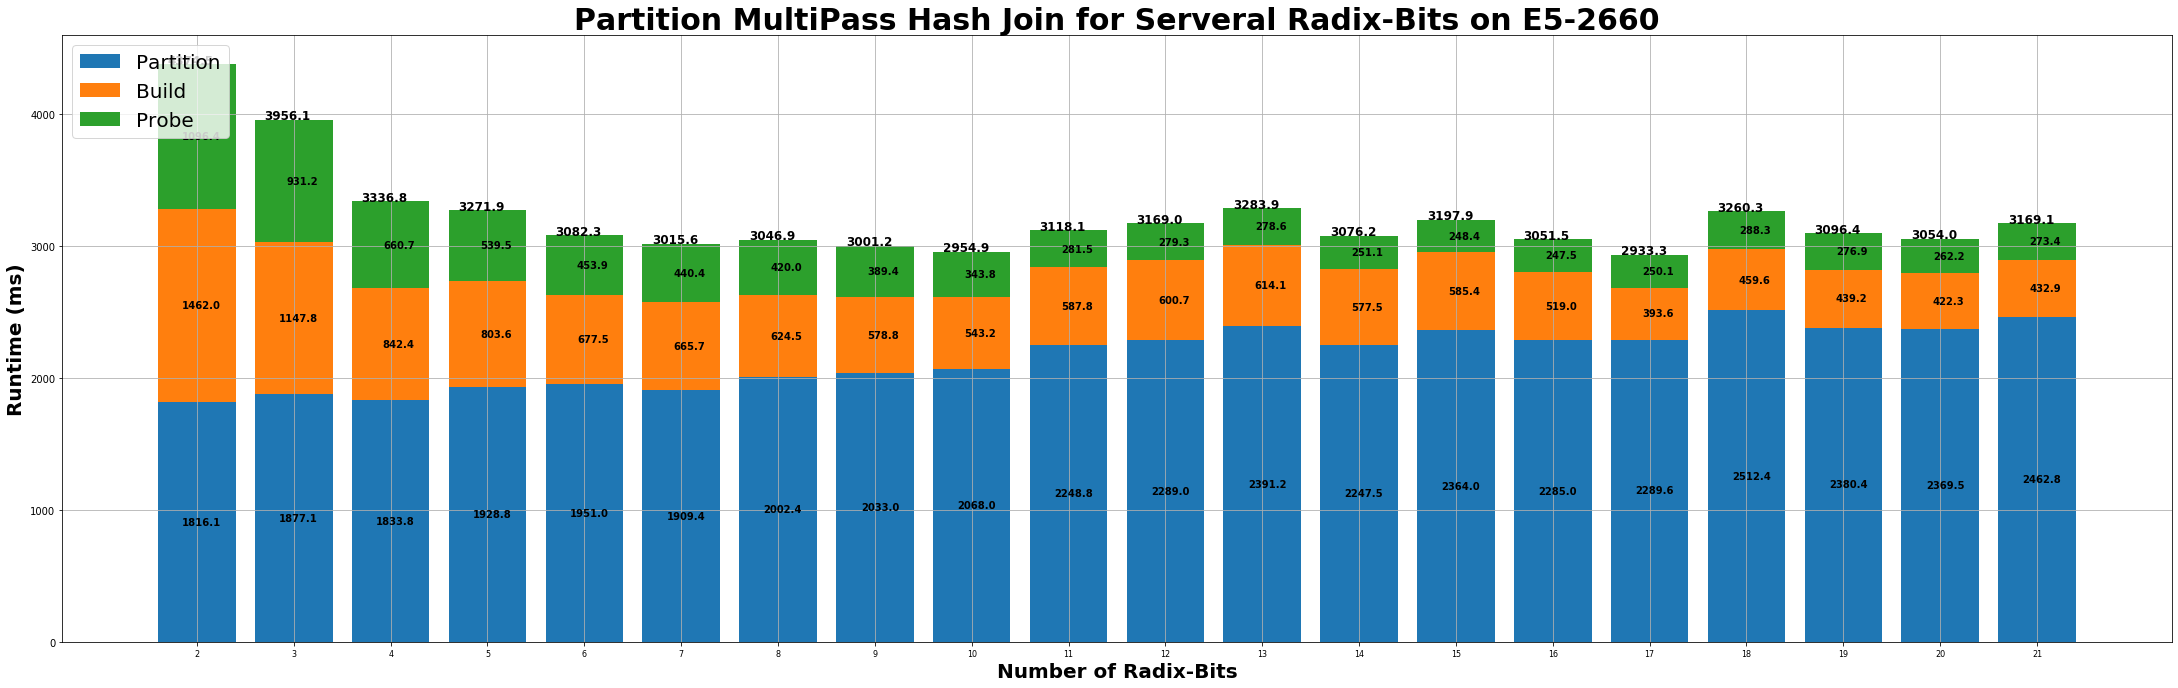

<Figure size 28800x14400 with 0 Axes>

In [187]:
df_e5_2    = pd.read_csv("E5-2660/PartitionMultiPassHashJoin.csv")
bits   = df_e5_2['bits']
bits  = np.array([str(item) for item in bits])
all_2  = df_e5_2['all']
all_2  = np.array([float(item) for item in all_2])
partition_2  = df_e5_2['partition']
partition_2  = np.array([float(item) for item in partition_2])
build_2      = df_e5_2['build']
build_2      = np.array([float(item) for item in build_2])
probe_2      = df_e5_2['probe']
probe_2      = np.array([float(item) for item in probe_2])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_2, label='Partition')
ax.bar(bits, build_2, bottom=partition_2, label='Build')
ax.bar(bits, probe_2, bottom=(partition_2+build_2), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_2):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition MultiPass Hash Join for Serveral Radix-Bits on E5-2660', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

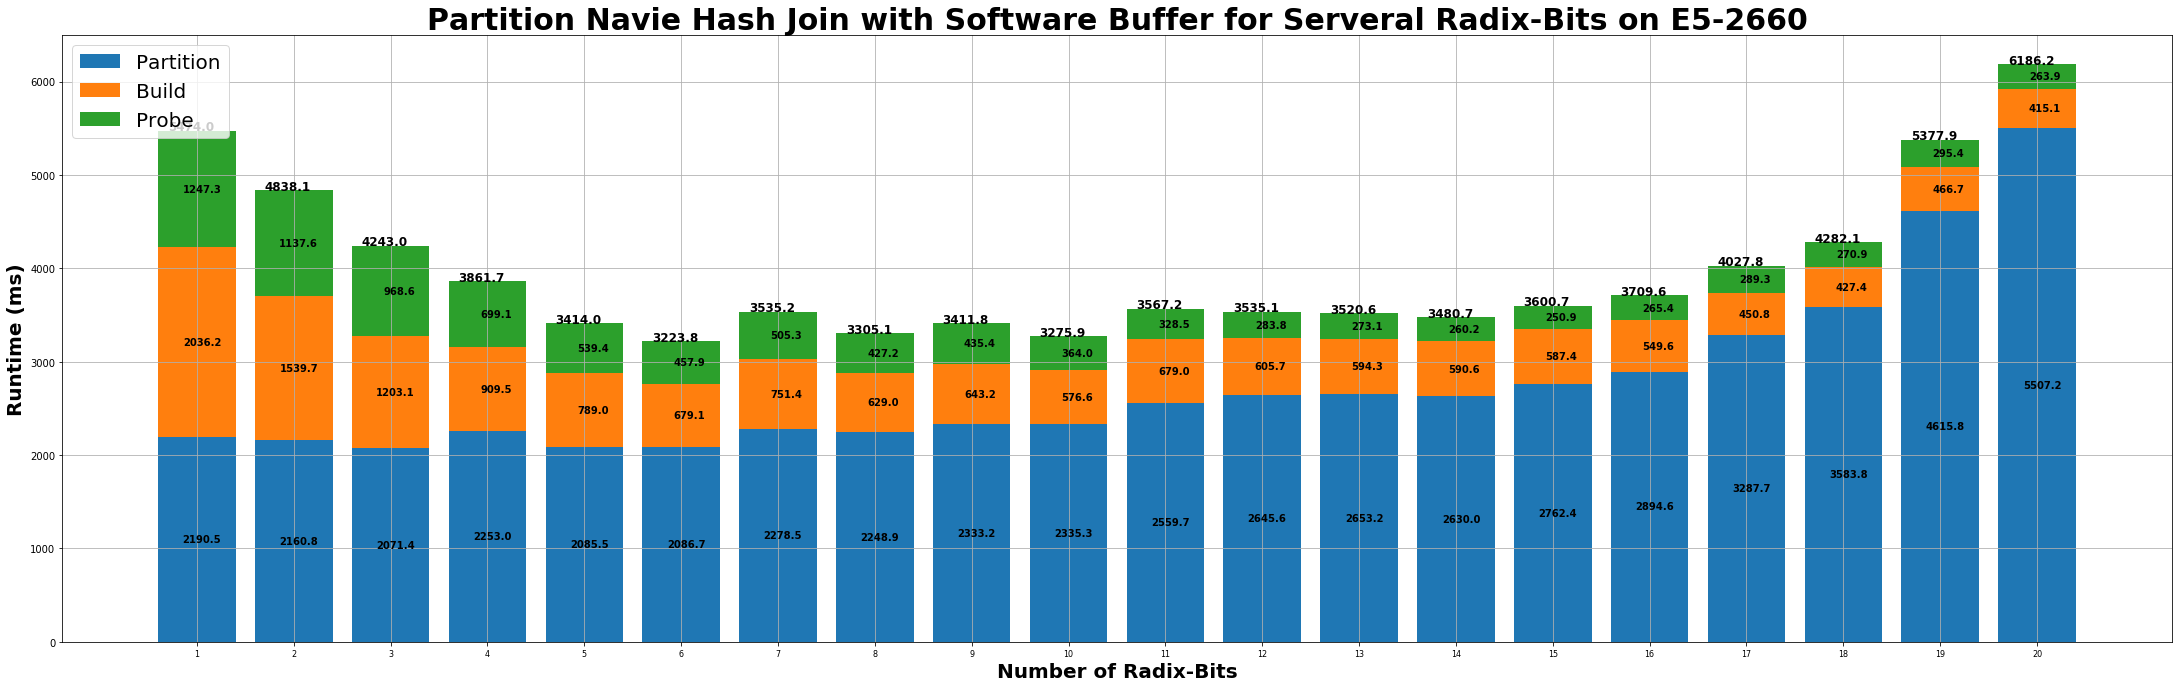

<Figure size 28800x14400 with 0 Axes>

In [188]:
df_e5_3    = pd.read_csv("E5-2660/PartitionNavieHashJoinSoftwareBuffer.csv")
bits   = df_e5_3['bits']
bits  = np.array([str(item) for item in bits])
all_3  = df_e5_3['all']
all_3  = np.array([float(item) for item in all_3])
partition_3  = df_e5_3['partition']
partition_3  = np.array([float(item) for item in partition_3])
build_3      = df_e5_3['build']
build_3      = np.array([float(item) for item in build_3])
probe_3      = df_e5_3['probe']
probe_3      = np.array([float(item) for item in probe_3])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_3, label='Partition')
ax.bar(bits, build_3, bottom=partition_3, label='Build')
ax.bar(bits, probe_3, bottom=(partition_3+build_3), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_3):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Navie Hash Join with Software Buffer for Serveral Radix-Bits on E5-2660', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

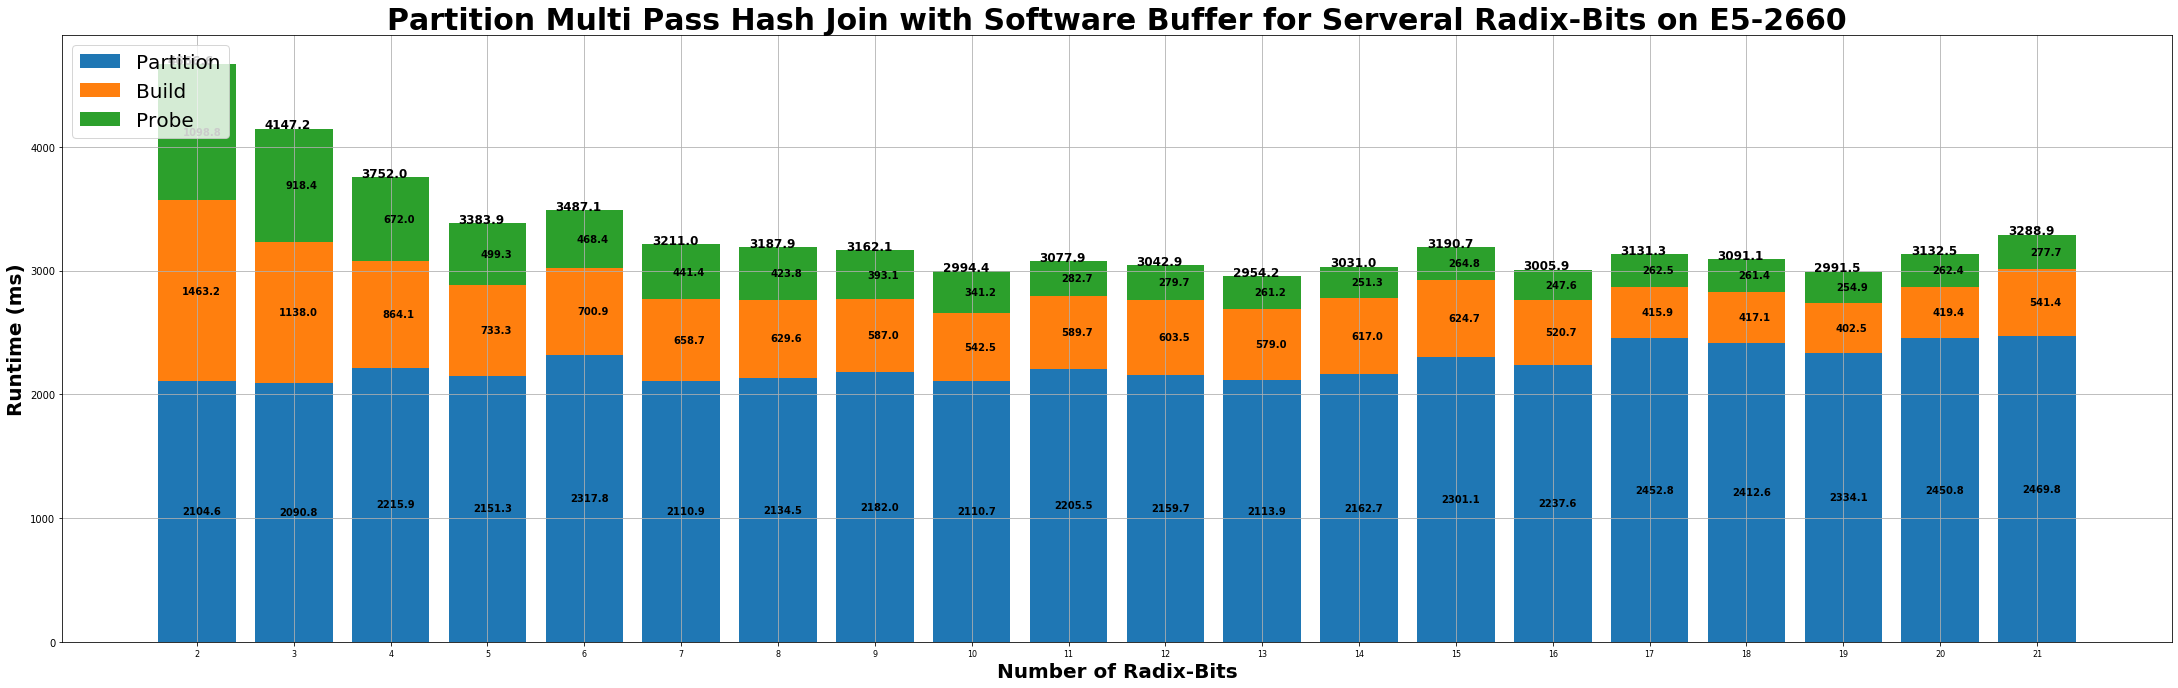

<Figure size 28800x14400 with 0 Axes>

In [189]:
df_e5_4    = pd.read_csv("E5-2660/PartitionMultiPassHashJoinSoftwareBuffer.csv")
bits   = df_e5_4['bits']
bits  = np.array([str(item) for item in bits])
all_4  = df_e5_4['all']
all_4  = np.array([float(item) for item in all_4])
partition_4  = df_e5_4['partition']
partition_4  = np.array([float(item) for item in partition_4])
build_4      = df_e5_4['build']
build_4      = np.array([float(item) for item in build_4])
probe_4      = df_e5_4['probe']
probe_4      = np.array([float(item) for item in probe_4])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_4, label='Partition')
ax.bar(bits, build_4, bottom=partition_4, label='Build')
ax.bar(bits, probe_4, bottom=(partition_4+build_4), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_4):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Multi Pass Hash Join with Software Buffer for Serveral Radix-Bits on E5-2660', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

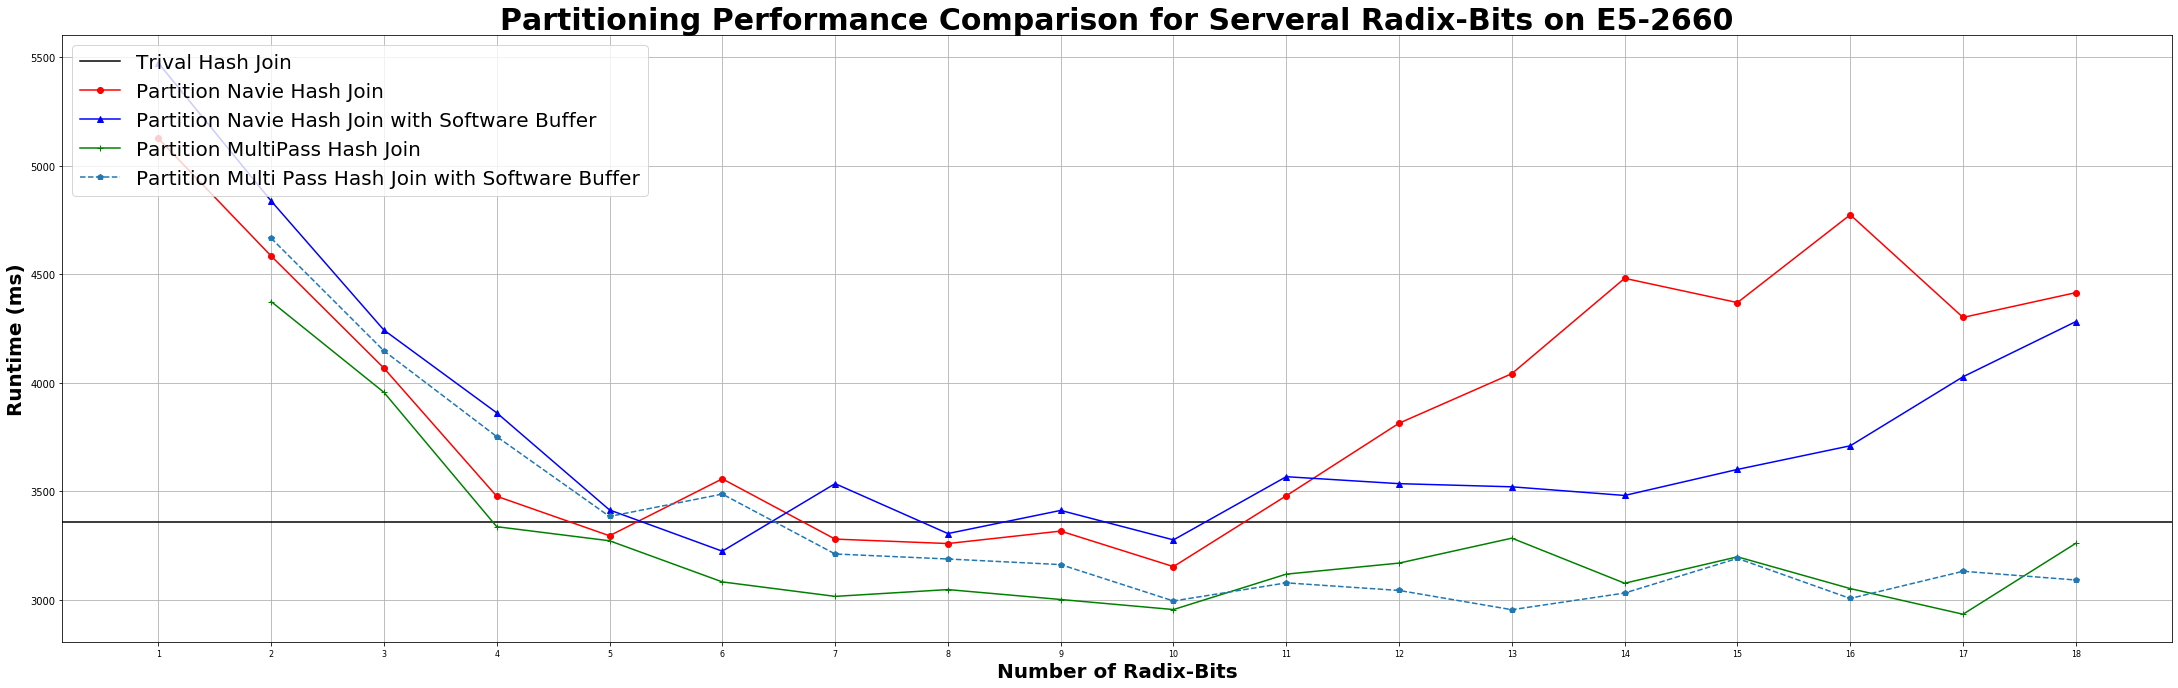

<Figure size 28800x14400 with 0 Axes>

In [190]:
df_e5_0   = pd.read_csv("E5-2660/TrivialHashJoin.csv")
all_0   = df_e5_0['all']

df_e5_1    = pd.read_csv("E5-2660/PartitionNavieHashJoin.csv")
bits   = df_e5_1['bits']
bits  = [str(item) for item in bits]

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()


ax.axhline(y=all_0[0], xmin=0.0, xmax=1.0, color='black')
plt.plot(bits[:18], all_1[:18], 'ro-', bits[:18], all_3[:18], 'b^-')
plt.plot(bits[1:18], all_2[:17], 'g+-', bits[1:18], all_4[:17], 'p--')

plt.title('Partitioning Performance Comparison for Serveral Radix-Bits on E5-2660', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
plt.legend(['Trival Hash Join', 'Partition Navie Hash Join', 'Partition Navie Hash Join with Software Buffer', 'Partition MultiPass Hash Join', 'Partition Multi Pass Hash Join with Software Buffer'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

### i9-7900X

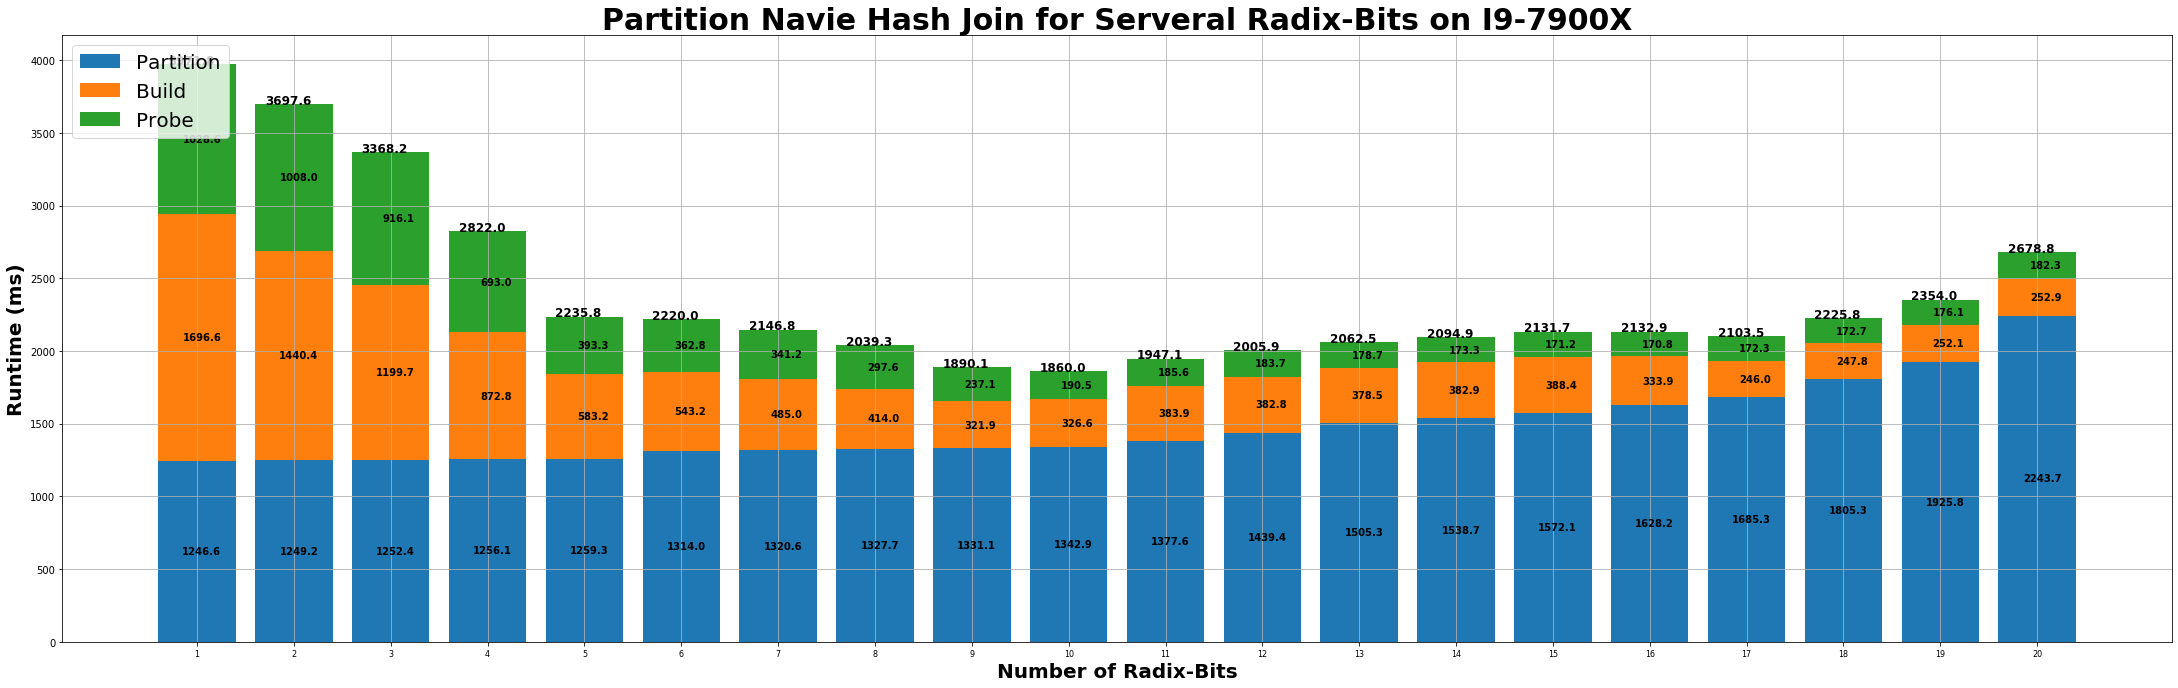

<Figure size 28800x14400 with 0 Axes>

In [191]:
df_i9_1    = pd.read_csv("I9-7900X/PartitionNavieHashJoin.csv")
bits   = df_i9_1['bits']
bits  = np.array([str(item) for item in bits])
all_1  = df_i9_1['all']
all_1  = np.array([float(item) for item in all_1])
partition_1  = df_i9_1['partition']
partition_1  = np.array([float(item) for item in partition_1])
build_1      = df_i9_1['build']
build_1      = np.array([float(item) for item in build_1])
probe_1      = df_i9_1['probe']
probe_1      = np.array([float(item) for item in probe_1])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_1, label='Partition')
ax.bar(bits, build_1, bottom=partition_1, label='Build')
ax.bar(bits, probe_1, bottom=(partition_1+build_1), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_1):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Navie Hash Join for Serveral Radix-Bits on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
plt.figure(figsize=(400,200))
plt.show()

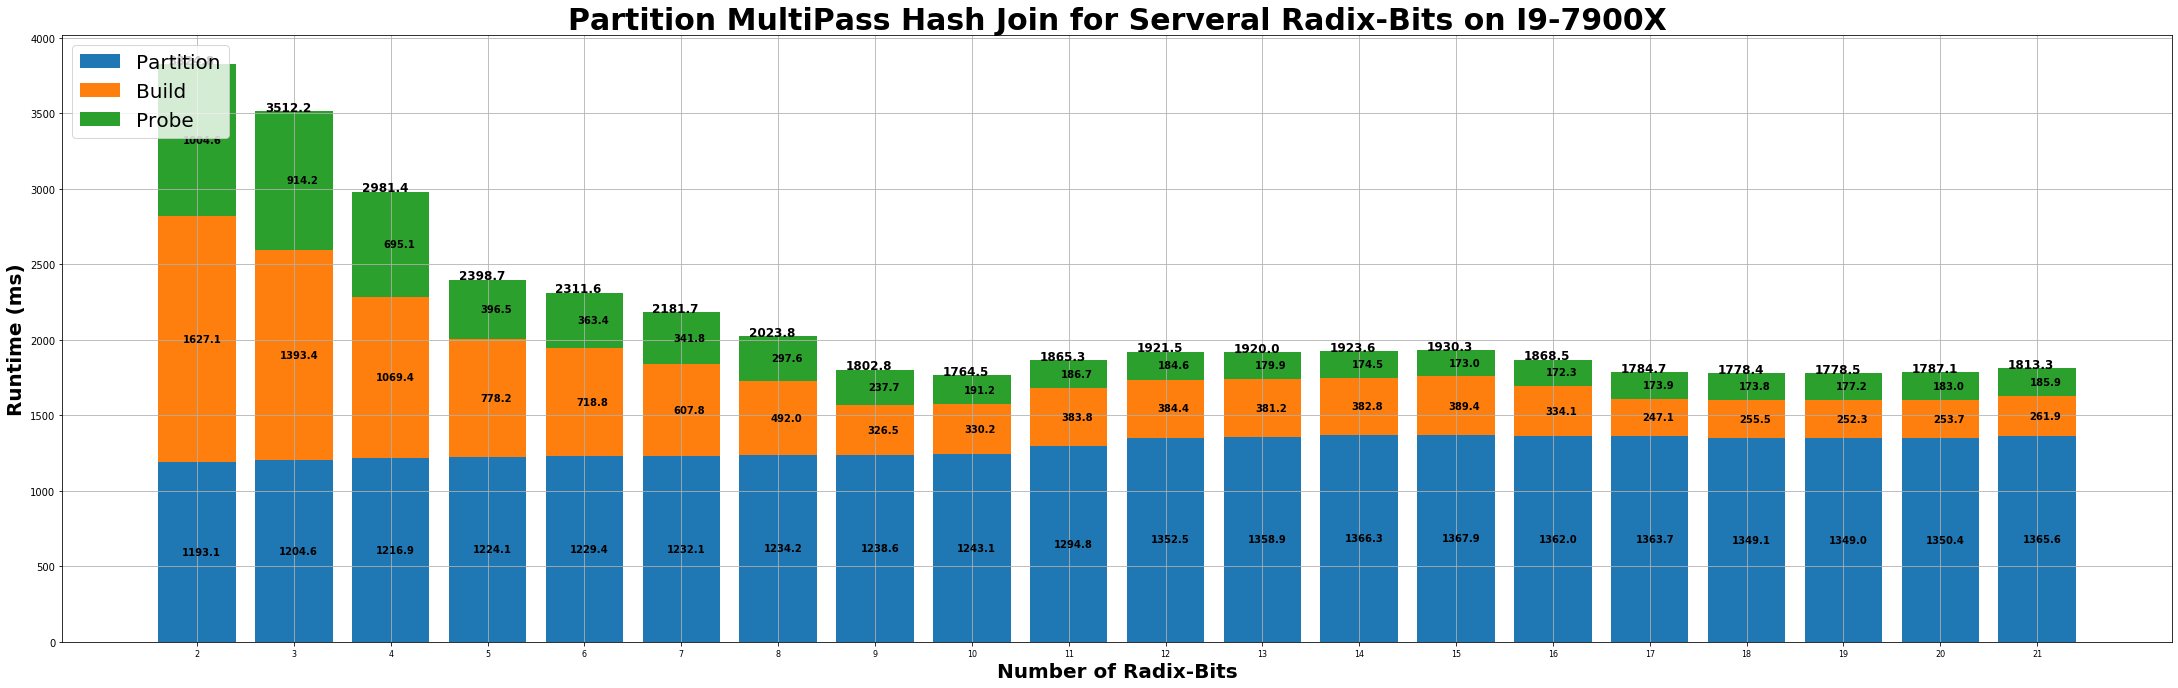

<Figure size 28800x14400 with 0 Axes>

In [192]:
df_i9_2    = pd.read_csv("I9-7900X/PartitionMultiPassHashJoin.csv")
bits   = df_i9_2['bits']
bits  = np.array([str(item) for item in bits])
all_2  = df_i9_2['all']
all_2  = np.array([float(item) for item in all_2])
partition_2  = df_i9_2['partition']
partition_2  = np.array([float(item) for item in partition_2])
build_2      = df_i9_2['build']
build_2      = np.array([float(item) for item in build_2])
probe_2      = df_i9_2['probe']
probe_2      = np.array([float(item) for item in probe_2])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_2, label='Partition')
ax.bar(bits, build_2, bottom=partition_2, label='Build')
ax.bar(bits, probe_2, bottom=(partition_2+build_2), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_2):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition MultiPass Hash Join for Serveral Radix-Bits on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
plt.figure(figsize=(400,200))
plt.show()

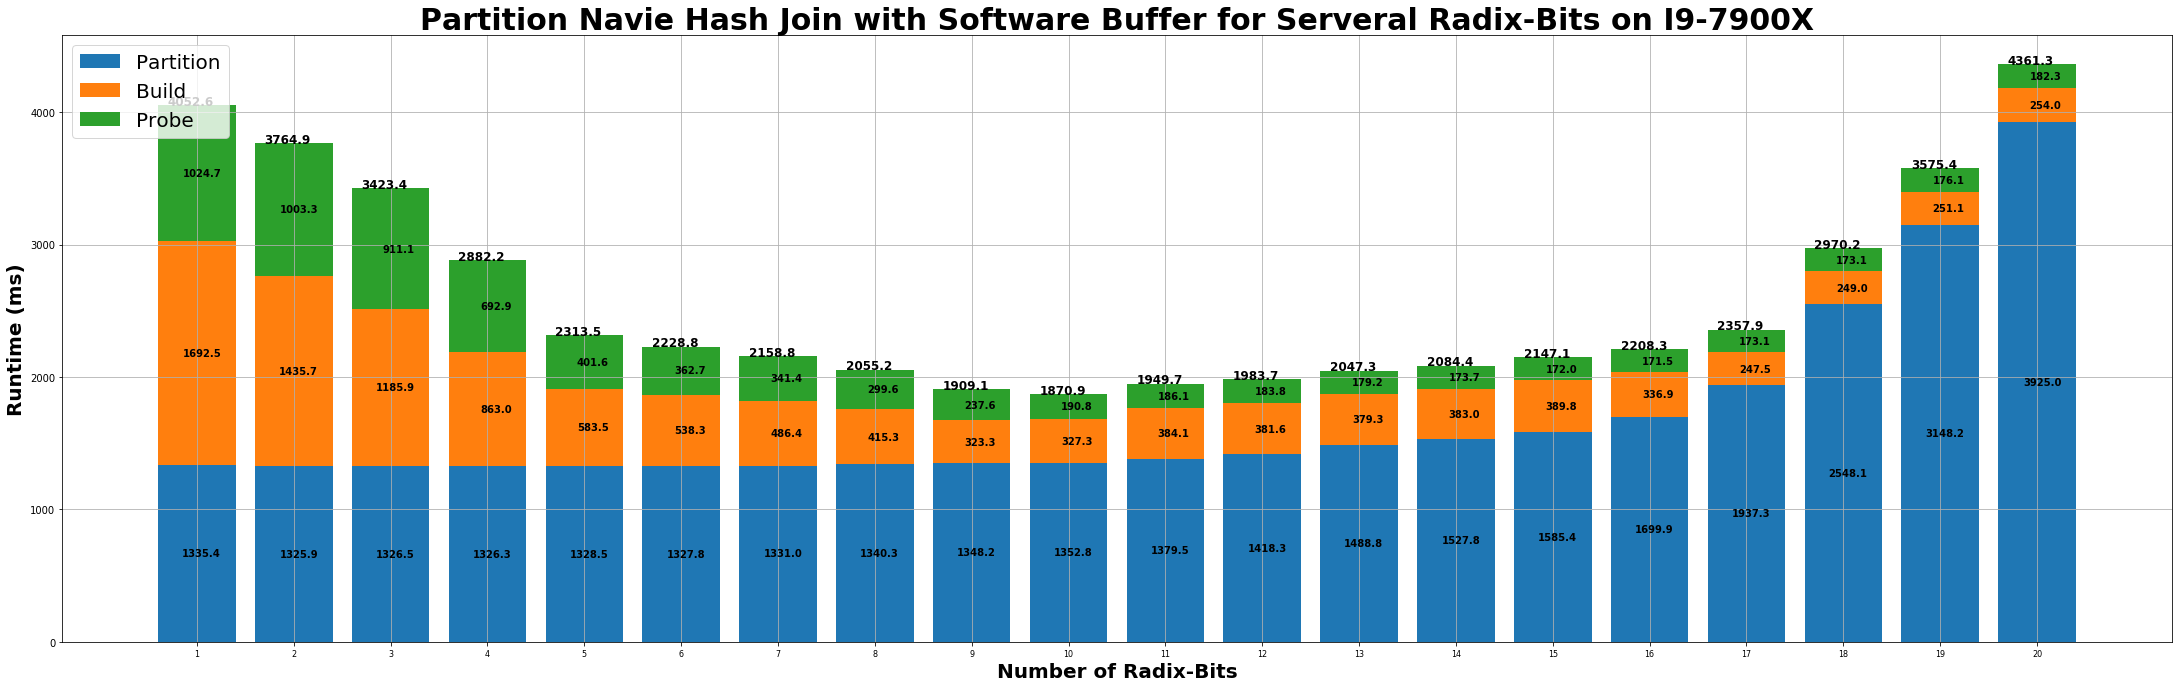

<Figure size 28800x14400 with 0 Axes>

In [193]:
df_i9_3    = pd.read_csv("I9-7900X/PartitionNavieHashJoinSoftwareBuffer.csv")
bits   = df_i9_3['bits']
bits  = np.array([str(item) for item in bits])
all_3  = df_i9_3['all']
all_3  = np.array([float(item) for item in all_3])
partition_3  = df_i9_3['partition']
partition_3  = np.array([float(item) for item in partition_3])
build_3      = df_i9_3['build']
build_3      = np.array([float(item) for item in build_3])
probe_3      = df_i9_3['probe']
probe_3      = np.array([float(item) for item in probe_3])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_3, label='Partition')
ax.bar(bits, build_3, bottom=partition_3, label='Build')
ax.bar(bits, probe_3, bottom=(partition_3+build_3), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_3):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Navie Hash Join with Software Buffer for Serveral Radix-Bits on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
plt.figure(figsize=(400,200))
plt.show()

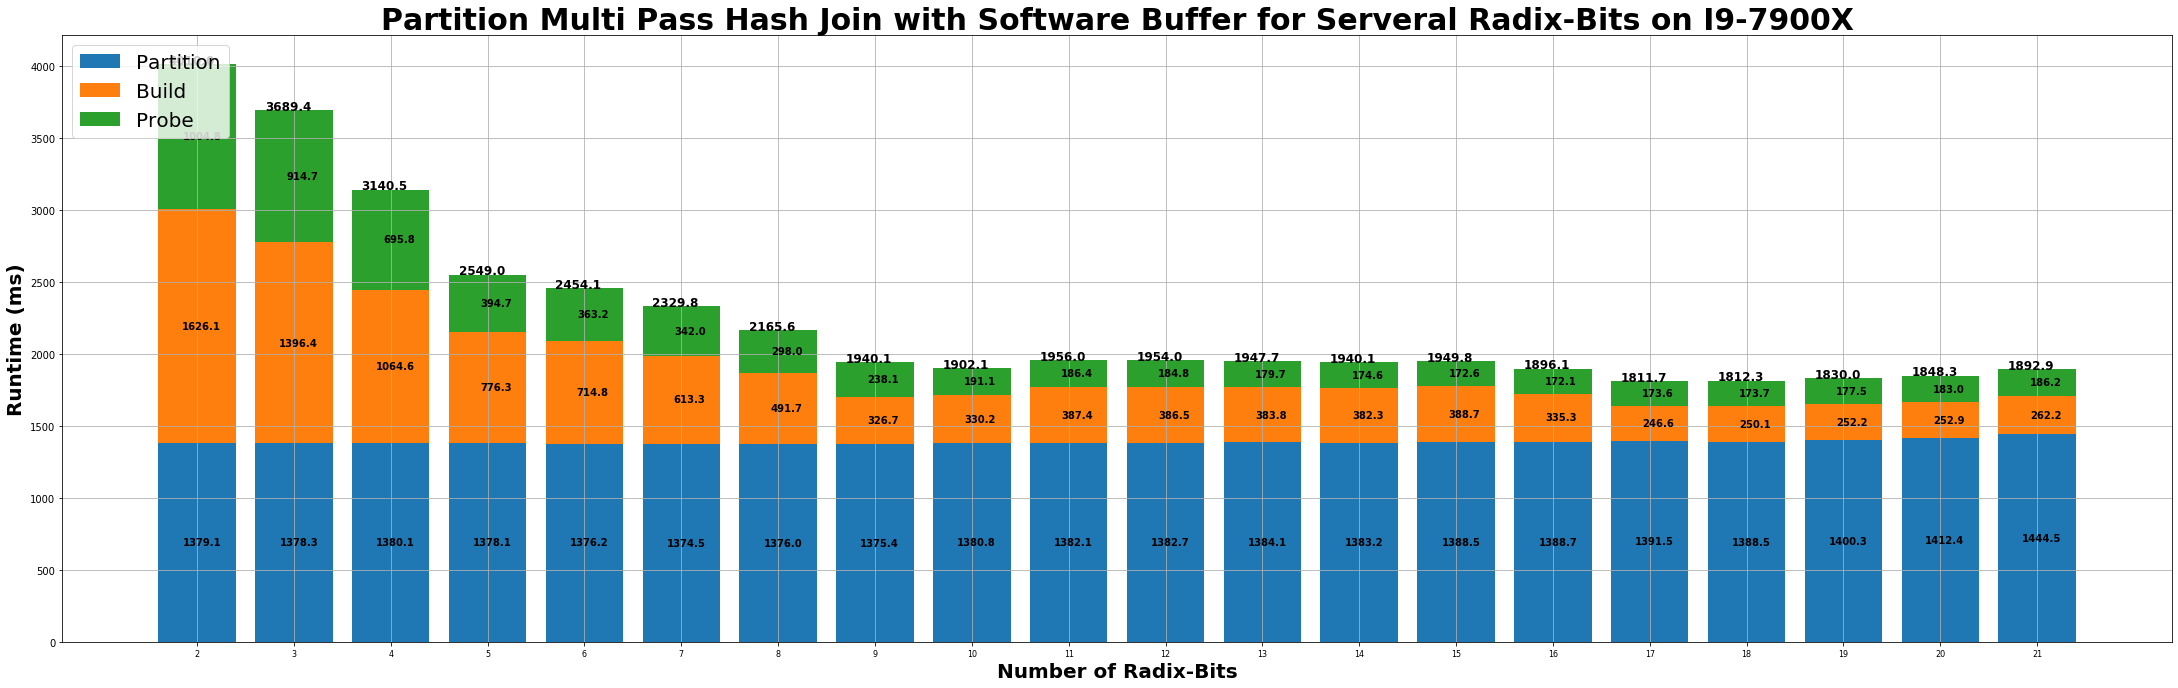

<Figure size 28800x14400 with 0 Axes>

In [194]:
df_i9_4    = pd.read_csv("I9-7900X/PartitionMultiPassHashJoinSoftwareBuffer.csv")
bits   = df_i9_4['bits']
bits  = np.array([str(item) for item in bits])
all_4  = df_i9_4['all']
all_4  = np.array([float(item) for item in all_4])
partition_4  = df_i9_4['partition']
partition_4  = np.array([float(item) for item in partition_4])
build_4      = df_i9_4['build']
build_4      = np.array([float(item) for item in build_4])
probe_4      = df_i9_4['probe']
probe_4      = np.array([float(item) for item in probe_4])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()
ax.bar(bits, partition_4, label='Partition')
ax.bar(bits, build_4, bottom=partition_4, label='Build')
ax.bar(bits, probe_4, bottom=(partition_4+build_4), label='Probe')

for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()

    # The width of the bar is the data value and can used as the label
    label_text = f'{height:.1f}'  # f'{height:.2f}' to format decimal values

    # ax.text(x, y, text)
    label_x = x + width - 0.15  # adjust 0.15 to center the label
    label_y = y + height / 2
    ax.text(label_x, label_y, label_text, ha='right', va='center', fontsize=10, fontweight='bold')
    
    
for index,data in enumerate(all_4):
    plt.text(x=index-0.3, y =data+1 , s=f"{data}", fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=20)

plt.title('Partition Multi Pass Hash Join with Software Buffer for Serveral Radix-Bits on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
# plt.legend(['Stride 8 Bytes', 'Stride 64 Bytes', 'Stride 128 Byte', 'Stride 256 Bytes', 'Stride 32KiBytes'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

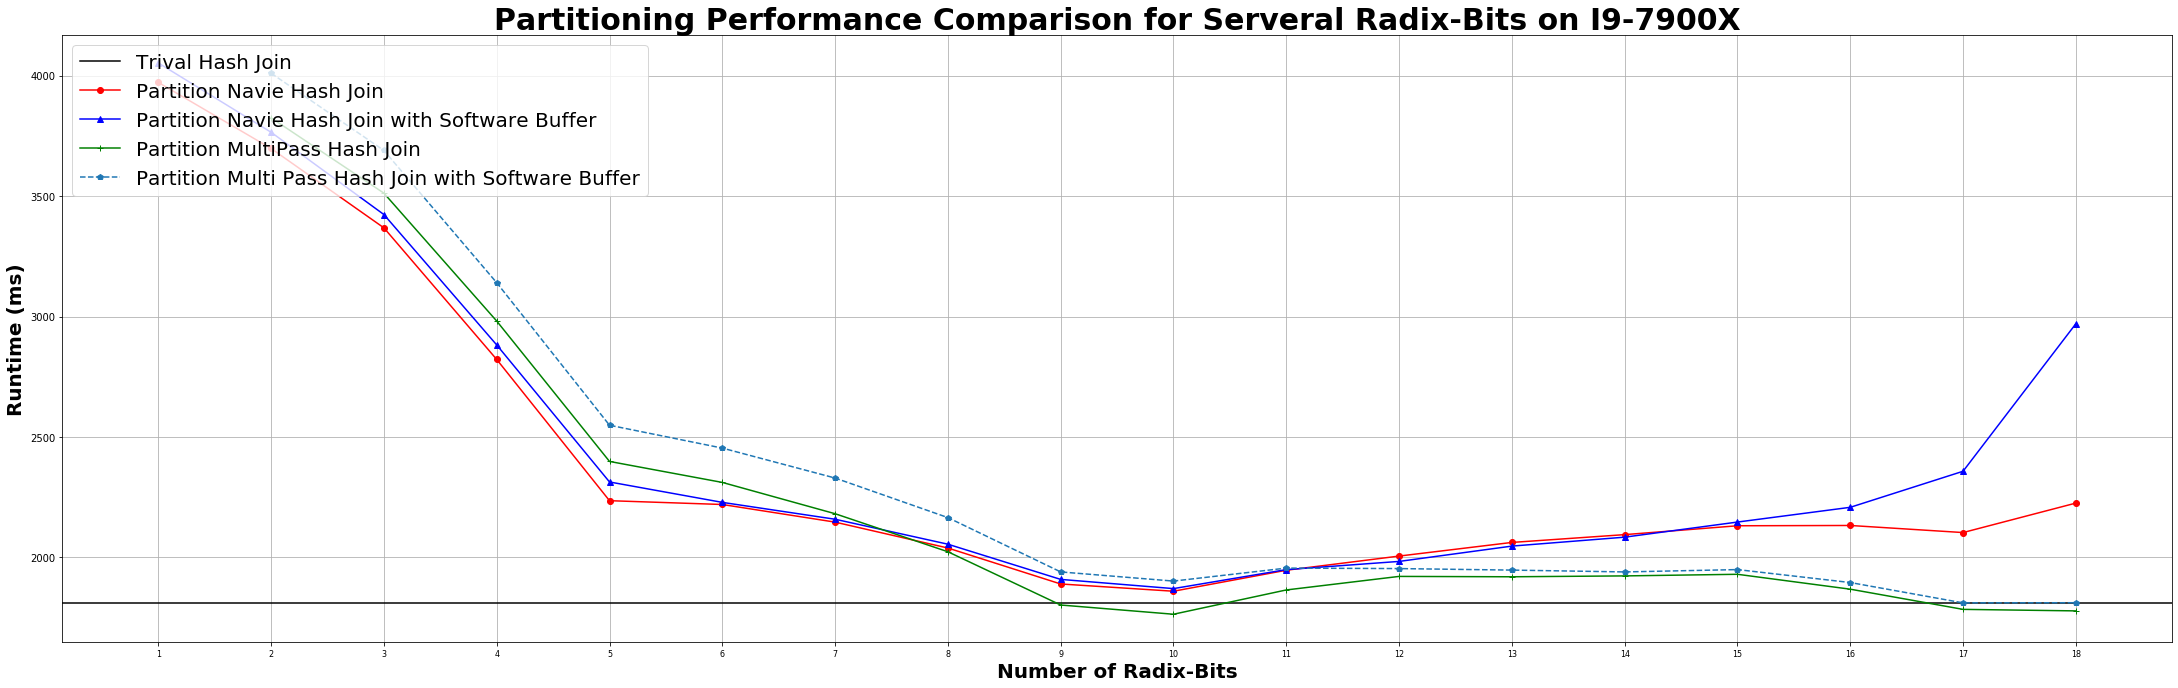

<Figure size 28800x14400 with 0 Axes>

In [195]:
df_i9_0   = pd.read_csv("I9-7900X/TrivialHashJoin.csv")
all_0   = df_i9_0['all']

df_i9_1    = pd.read_csv("I9-7900X/PartitionNavieHashJoin.csv")
bits   = df_i9_1['bits']
bits  = [str(item) for item in bits]

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()


ax.axhline(y=all_0[0], xmin=0.0, xmax=1.0, color='black')
plt.plot(bits[:18], all_1[:18], 'ro-', bits[:18], all_3[:18], 'b^-')
plt.plot(bits[1:18], all_2[:17], 'g+-', bits[1:18], all_4[:17], 'p--')

plt.title('Partitioning Performance Comparison for Serveral Radix-Bits on I9-7900X', fontsize=30, fontweight='bold')
plt.xlabel('Number of Radix-Bits', fontsize=20, fontweight='bold')
plt.ylabel('Runtime (ms)', fontsize=20, fontweight='bold')
plt.legend(['Trival Hash Join', 'Partition Navie Hash Join', 'Partition Navie Hash Join with Software Buffer', 'Partition MultiPass Hash Join', 'Partition Multi Pass Hash Join with Software Buffer'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()

## Throughput of Hash Join with two 512MiB-sized Relations on Different CPUs

As multiple relevant papers have mentioned, the performance highly depends on the CPU architecture. size of dataset, hash function as well as partition distribution. So I conduct the experiments on several CPUs and plot the best throughout on each CPU as well as on each type of hash join.  

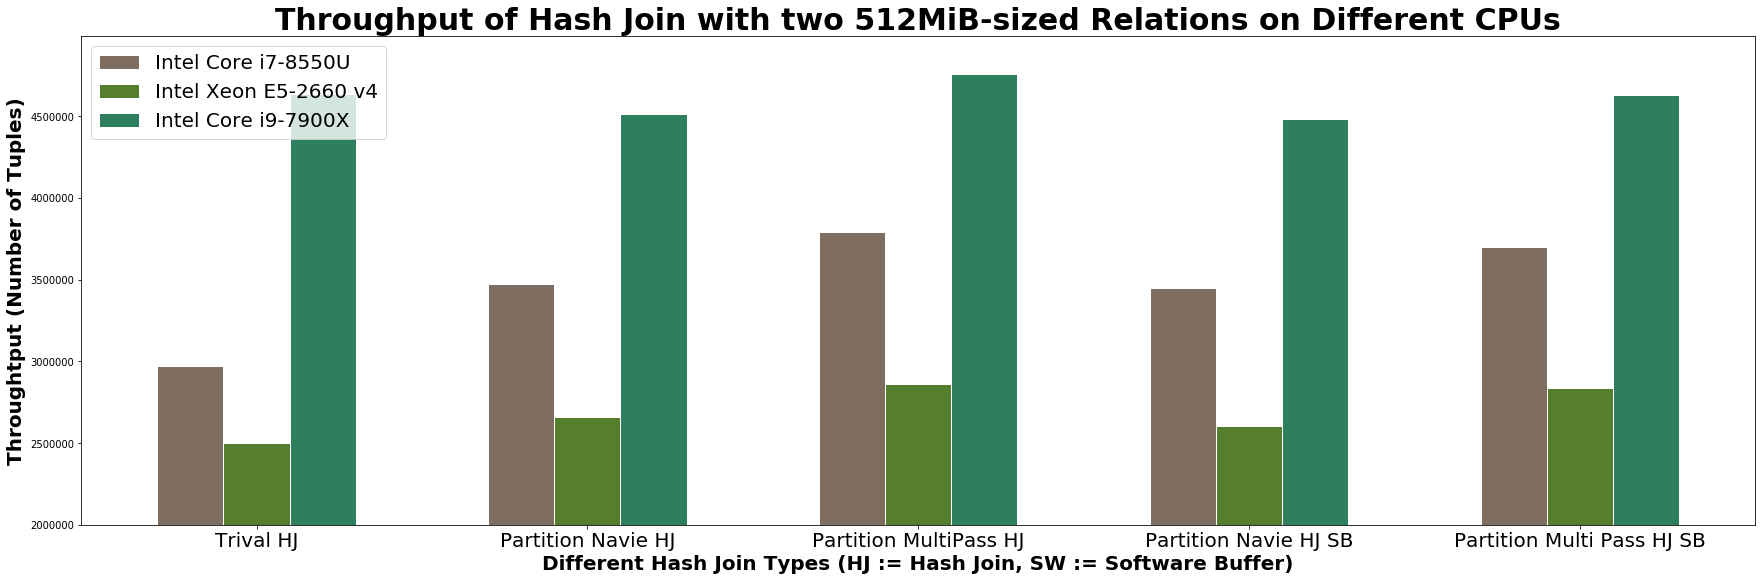

In [239]:
df_i7_0   = pd.read_csv("I7-8550u/TrivialHashJoin.csv")
i7_all_0   = df_i7_0['all']

df_i7_1    = pd.read_csv("I7-8550u/PartitionNavieHashJoin.csv")
i7_all_1  = df_i7_1['all']
i7_all_1  = np.array([float(item) for item in i7_all_1])
i7_partition_1  = df_i7_1['partition']
i7_partition_1  = np.array([float(item) for item in i7_partition_1])
i7_build_1      = df_i7_1['build']
i7_build_1      = np.array([float(item) for item in i7_build_1])
i7_probe_1      = df_i7_1['probe']
i7_probe_1      = np.array([float(item) for item in i7_probe_1])

df_i7_2    = pd.read_csv("I7-8550u/PartitionMultiPassHashJoin.csv")
i7_all_2  = df_i7_2['all']
i7_all_2  = np.array([float(item) for item in i7_all_2])
i7_partition_2  = df_i7_2['partition']
i7_partition_2  = np.array([float(item) for item in i7_partition_2])
i7_build_2      = df_i7_2['build']
i7_build_2      = np.array([float(item) for item in i7_build_2])
i7_probe_2      = df_i7_2['probe']
i7_probe_2      = np.array([float(item) for item in i7_probe_2])

df_i7_3    = pd.read_csv("I7-8550u/PartitionNavieHashJoinSoftwareBuffer.csv")
i7_all_3  = df_i7_3['all']
i7_all_3  = np.array([float(item) for item in i7_all_3])
i7_partition_3  = df_i7_3['partition']
i7_partition_3  = np.array([float(item) for item in i7_partition_3])
i7_build_3      = df_i7_3['build']
i7_build_3      = np.array([float(item) for item in i7_build_3])
i7_probe_3      = df_i7_3['probe']
i7_probe_3      = np.array([float(item) for item in i7_probe_3])

df_i7_4    = pd.read_csv("I7-8550u/PartitionMultiPassHashJoinSoftwareBuffer.csv")
i7_all_4  = df_i7_4['all']
i7_all_4  = np.array([float(item) for item in i7_all_4])
i7_partition_4  = df_i7_4['partition']
i7_partition_4  = np.array([float(item) for item in i7_partition_4])
i7_build_4      = df_i7_4['build']
i7_build_4      = np.array([float(item) for item in i7_build_4])
i7_probe_4      = df_i7_4['probe']
i7_probe_4      = np.array([float(item) for item in i7_probe_4])

df_e5_0   = pd.read_csv("E5-2660/TrivialHashJoin.csv")
e5_all_0   = df_e5_0['all']

df_e5_1    = pd.read_csv("E5-2660/PartitionNavieHashJoin.csv")
e5_all_1  = df_e5_1['all']
e5_all_1  = np.array([float(item) for item in e5_all_1])
e5_partition_1  = df_e5_1['partition']
e5_partition_1  = np.array([float(item) for item in e5_partition_1])
e5_build_1      = df_e5_1['build']
e5_build_1      = np.array([float(item) for item in e5_build_1])
e5_probe_1      = df_e5_1['probe']
e5_probe_1      = np.array([float(item) for item in e5_probe_1])

df_e5_2    = pd.read_csv("E5-2660/PartitionMultiPassHashJoin.csv")
e5_all_2  = df_e5_2['all']
e5_all_2  = np.array([float(item) for item in e5_all_2])
e5_partition_2  = df_e5_2['partition']
e5_partition_2  = np.array([float(item) for item in e5_partition_2])
e5_build_2      = df_e5_2['build']
e5_build_2      = np.array([float(item) for item in e5_build_2])
e5_probe_2      = df_e5_2['probe']
e5_probe_2      = np.array([float(item) for item in e5_probe_2])

df_e5_3    = pd.read_csv("E5-2660/PartitionNavieHashJoinSoftwareBuffer.csv")
e5_all_3  = df_e5_3['all']
e5_all_3  = np.array([float(item) for item in e5_all_3])
e5_partition_3  = df_e5_3['partition']
e5_partition_3  = np.array([float(item) for item in e5_partition_3])
e5_build_3      = df_e5_3['build']
e5_build_3      = np.array([float(item) for item in e5_build_3])
e5_probe_3      = df_e5_3['probe']
e5_probe_3      = np.array([float(item) for item in e5_probe_3])

df_e5_4    = pd.read_csv("E5-2660/PartitionMultiPassHashJoinSoftwareBuffer.csv")
e5_all_4  = df_e5_4['all']
e5_all_4  = np.array([float(item) for item in e5_all_4])
e5_partition_4  = df_e5_4['partition']
e5_partition_4  = np.array([float(item) for item in e5_partition_4])
e5_build_4      = df_e5_4['build']
e5_build_4      = np.array([float(item) for item in e5_build_4])
e5_probe_4      = df_e5_4['probe']
e5_probe_4      = np.array([float(item) for item in e5_probe_4])


df_i9_0   = pd.read_csv("I9-7900X/TrivialHashJoin.csv")
i9_all_0   = df_i9_0['all']

df_i9_1    = pd.read_csv("I9-7900X/PartitionNavieHashJoin.csv")
i9_all_1  = df_i9_1['all']
i9_all_1  = np.array([float(item) for item in i9_all_1])
i9_partition_1  = df_i9_1['partition']
i9_partition_1  = np.array([float(item) for item in i9_partition_1])
i9_build_1      = df_i9_1['build']
i9_build_1      = np.array([float(item) for item in i9_build_1])
i9_probe_1      = df_i9_1['probe']
i9_probe_1      = np.array([float(item) for item in i9_probe_1])

df_i9_2    = pd.read_csv("I9-7900X/PartitionMultiPassHashJoin.csv")
i9_all_2  = df_i9_2['all']
i9_all_2  = np.array([float(item) for item in i9_all_2])
i9_partition_2  = df_i9_2['partition']
i9_partition_2  = np.array([float(item) for item in i9_partition_2])
i9_build_2      = df_i9_2['build']
i9_build_2      = np.array([float(item) for item in i9_build_2])
i9_probe_2      = df_i9_2['probe']
i9_probe_2      = np.array([float(item) for item in i9_probe_2])

df_i9_3    = pd.read_csv("I9-7900X/PartitionNavieHashJoinSoftwareBuffer.csv")
i9_all_3  = df_i9_3['all']
i9_all_3  = np.array([float(item) for item in i9_all_3])
i9_partition_3  = df_i9_3['partition']
i9_partition_3  = np.array([float(item) for item in i9_partition_3])
i9_build_3      = df_i9_3['build']
i9_build_3      = np.array([float(item) for item in i9_build_3])
i9_probe_3      = df_i9_3['probe']
i9_probe_3      = np.array([float(item) for item in i9_probe_3])


df_i9_4    = pd.read_csv("I9-7900X/PartitionMultiPassHashJoinSoftwareBuffer.csv")
i9_all_4  = df_i9_4['all']
i9_all_4  = np.array([float(item) for item in i9_all_4])
i9_partition_4  = df_i9_4['partition']
i9_partition_4  = np.array([float(item) for item in i9_partition_4])
i9_build_4      = df_i9_4['build']
i9_build_4      = np.array([float(item) for item in i9_build_4])
i9_probe_4      = df_i9_4['probe']
i9_probe_4      = np.array([float(item) for item in i9_probe_4])


df_i7_th = [0, 0, 0, 0, 0]
df_i7_th[0] = (1 << 23) / (min(i7_all_0) / 1000)
df_i7_th[1] = (1 << 23) / (min(i7_all_1) / 1000)
df_i7_th[2] = (1 << 23) / (min(i7_all_2) / 1000)
df_i7_th[3] = (1 << 23) / (min(i7_all_3) / 1000)
df_i7_th[4] = (1 << 23) / (min(i7_all_4) / 1000)

df_e5_th = [0, 0, 0, 0, 0]
df_e5_th[0] = (1 << 23) / (min(e5_all_0) / 1000)
df_e5_th[1] = (1 << 23) / (min(e5_all_1) / 1000)
df_e5_th[2] = (1 << 23) / (min(e5_all_2) / 1000)
df_e5_th[3] = (1 << 23) / (min(e5_all_3) / 1000)
df_e5_th[4] = (1 << 23) / (min(e5_all_4) / 1000)

df_i9_th = [0, 0, 0, 0, 0]
df_i9_th[0] = (1 << 23) / (min(i9_all_0) / 1000)
df_i9_th[1] = (1 << 23) / (min(i9_all_1) / 1000)
df_i9_th[2] = (1 << 23) / (min(i9_all_2) / 1000)
df_i9_th[3] = (1 << 23) / (min(i9_all_3) / 1000)
df_i9_th[4] = (1 << 23) / (min(i9_all_4) / 1000)


# set width of bar
barWidth = 0.2
# Set position of bar on X axis
r1 = np.arange(len(df_i7_th))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


# Make the plot
plt.bar(r1, df_i7_th, color='#7f6d5f', width=barWidth, edgecolor='white', label='Intel Core i7-8550U')
plt.bar(r2, df_e5_th, color='#557f2d', width=barWidth, edgecolor='white', label='Intel Xeon E5-2660 v4')
plt.bar(r3, df_i9_th, color='#2d7f5e', width=barWidth, edgecolor='white', label='Intel Core i9-7900X')
 
# Add xticks on the middle of the group bars
plt.title('Throughput of Hash Join with two 512MiB-sized Relations on Different CPUs', fontsize=30, fontweight='bold')
plt.xlabel('Different Hash Join Types (HJ := Hash Join, SW := Software Buffer)', fontsize=20, fontweight='bold')
plt.ylabel('Throughtput (Number of Tuples)', fontsize=20, fontweight='bold')
plt.xticks([r + barWidth for r in range(len(df_i7_th))], ['Trival HJ', 'Partition Navie HJ', 'Partition MultiPass HJ', 'Partition Navie HJ SB', 'Partition Multi Pass HJ SB'], fontsize=20)
plt.ylim(bottom=2000000)
# Create legend & Show graphic
plt.legend(loc='upper left', fontsize=20)
plt.show()


# Appendix
- Core i7-8550U - Intel: https://en.wikichip.org/wiki/intel/core_i7/i7-8550u
- Core i9-7900X - Intel: https://en.wikichip.org/wiki/intel/core_i9/i9-7900x
- Xeon E5-2660 v4 - Intel: https://en.wikichip.org/wiki/intel/xeon_e5/e5-2660_v4

# TODO & Question:
- break down into CPU time, TLB miss, Cache miss -> hardware metrics

- Why difference of different hash joins on I9 is SUPER little? For me the trivial hash join produce already very good performance. With our hard-coded optimization can ONLY improve it about 10%. 

- Software buffer is also expensive (maybe I choose a too large tuple size -- 64Byte) -- this problem needs to be breakdown-ed into hardware metrics. Refer to following figure & the most right part:

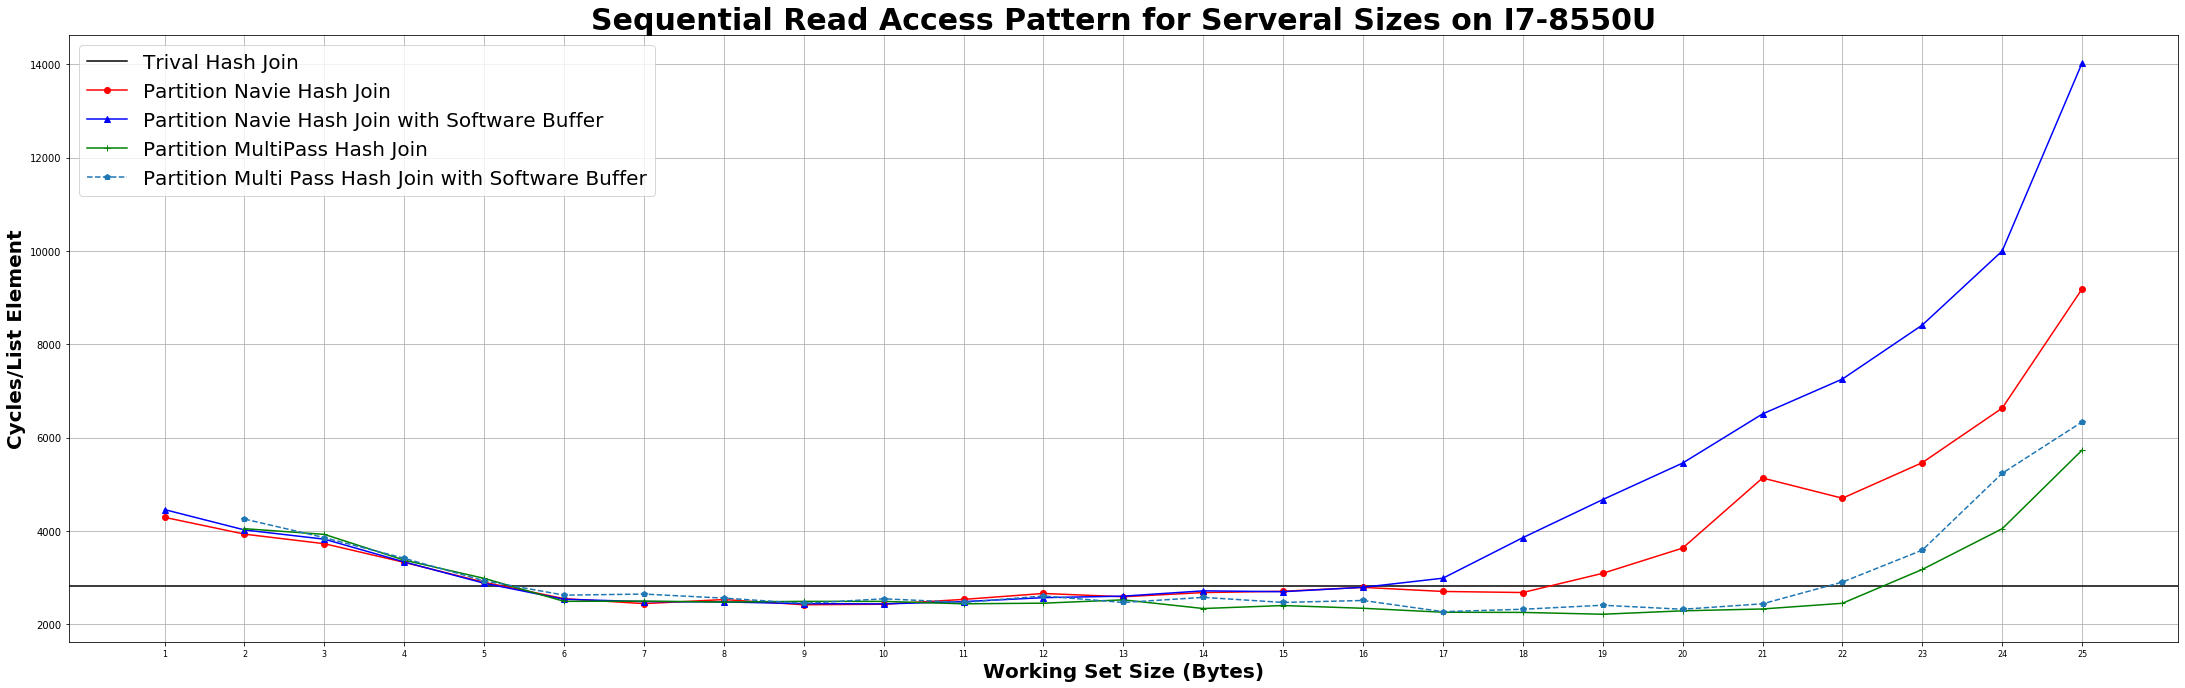

<Figure size 28800x14400 with 0 Axes>

In [205]:
# df_i7_1    = pd.read_csv("I7-8550u/PartitionNavieHashJoin.csv")
# bits   = df_i7_1['bits']
# bits  = [str(item) for item in bits]

df_i7_1    = pd.read_csv("I7-8550u/PartitionNavieHashJoin.csv")
bits   = df_i7_1['bits']
bits  = np.array([str(item) for item in bits])
all_1  = df_i7_1['all']
all_1  = np.array([float(item) for item in all_1])

df_i7_2    = pd.read_csv("I7-8550u/PartitionMultiPassHashJoin.csv")
all_2  = df_i7_2['all']
all_2  = np.array([float(item) for item in all_2])

df_i7_3    = pd.read_csv("I7-8550u/PartitionNavieHashJoinSoftwareBuffer.csv")
all_3  = df_i7_3['all']
all_3  = np.array([float(item) for item in all_3])

df_i7_4    = pd.read_csv("I7-8550u/PartitionMultiPassHashJoinSoftwareBuffer.csv")
all_4  = df_i7_4['all']
all_4  = np.array([float(item) for item in all_4])

ax = plt.gca()
ax.grid(True)
plt.tick_params(axis='x', which='major', labelsize=8)
plt.tight_layout()


ax.axhline(y=2820, xmin=0.0, xmax=1.0, color='black')
plt.plot(bits, all_1, 'ro-', bits, all_3, 'b^-')
plt.plot(bits[1:], all_2, 'g+-', bits[1:], all_4, 'p--')

plt.title('Sequential Read Access Pattern for Serveral Sizes on I7-8550U', fontsize=30, fontweight='bold')
plt.xlabel('Working Set Size (Bytes)', fontsize=20, fontweight='bold')
plt.ylabel('Cycles/List Element', fontsize=20, fontweight='bold')
plt.legend(['Trival Hash Join', 'Partition Navie Hash Join', 'Partition Navie Hash Join with Software Buffer', 'Partition MultiPass Hash Join', 'Partition Multi Pass Hash Join with Software Buffer'], loc='upper left', fontsize=20)
plt.figure(figsize=(400,200))
plt.show()